In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import pandas_datareader.data as web
import yfinance as yf
import datetime
import seaborn as sns
import dateutil.parser
import statsmodels.api as sm
import seaborn as sns
from datetime import date
from datetime import datetime
from sklearn import metrics
from sklearn.preprocessing import RobustScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_absolute_percentage_error, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.neural_network import MLPClassifier, MLPRegressor
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse, meanabs
from pmdarima.arima import auto_arima
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Time Series Eval Metrics Method

In [2]:
def ts_eval_metrics(y_true, y_pred):
    print('Time Series Evaluation Metrics')
    print(f'MSE = {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE = {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE = {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE = {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'r2 = {metrics.r2_score(y_true, y_pred)}', end='\n\n')


In [3]:
aapl = yf.Ticker("SPY")

### Plot an initial time series
##### Reference
##### Chaudhari, S. (2021). Stationarity in time series analysis explained using Python. Mathematics and Econometrics. https://blog.quantinsti.com/stationarity

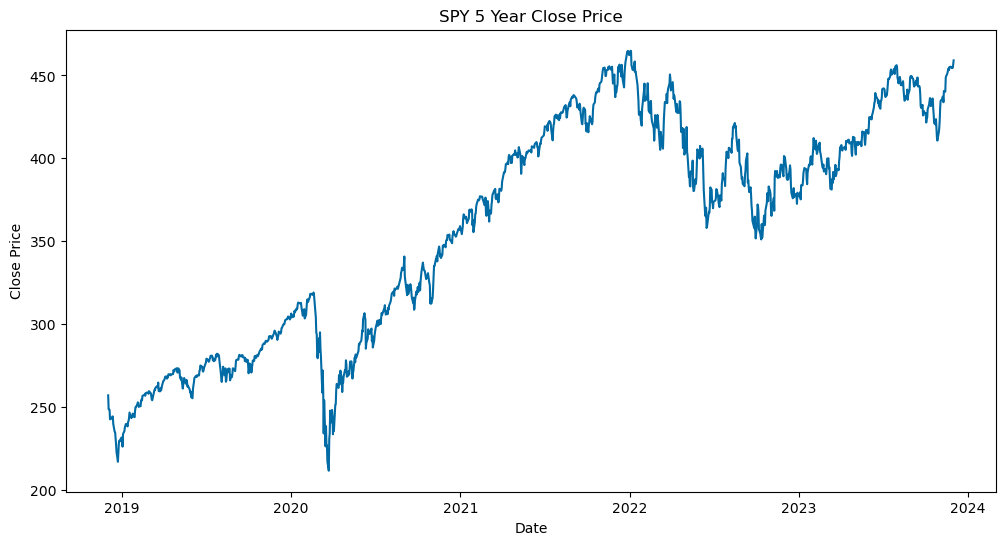

In [4]:
plt.style.use('tableau-colorblind10') #https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.figure(figsize=(12, 6))
close = aapl.history(period='5y')['Close']
plt.plot(close)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('SPY 5 Year Close Price')
plt.show()

In [103]:
close

Date
2018-12-03 00:00:00-05:00    256.936554
2018-12-04 00:00:00-05:00    248.611313
2018-12-06 00:00:00-05:00    248.234116
2018-12-07 00:00:00-05:00    242.466171
2018-12-10 00:00:00-05:00    242.926102
                                ...    
2023-11-27 00:00:00-05:00    454.480011
2023-11-28 00:00:00-05:00    454.929993
2023-11-29 00:00:00-05:00    454.609985
2023-11-30 00:00:00-05:00    456.399994
2023-12-01 00:00:00-05:00    459.100006
Name: Close, Length: 1258, dtype: float64

## Check stationarity

### Split Price into halves for statistical analysis

In [5]:
X = close.copy()
split = round(len(X)/2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
mean_percent_diff = (mean2 - mean1) / mean1 * 100
var1, var2 = X1.var(), X2.var()
var_percent_diff = (var2 - var1) / var1 * 100
print('mean1=%f, mean2=%3f, mean_percent_diff=%f' % (mean1, mean2, mean_percent_diff))
print('variance1=%f, variance2=%f, var_percent_diff=%f' % (var1, var2, var_percent_diff))

mean1=302.625765, mean2=415.748765, mean_percent_diff=37.380492
variance1=2132.327055, variance2=696.046062, var_percent_diff=-67.357444


### Augmented Dickey-Fuller Test
##### Check for stationarity where H0 = time series !stationary; H1 = time series = stationary
##### If p-value <= .05 or abs(test statistic)>critical value, reject H0

In [6]:
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])

ADF Statistic: -1.442585
p-value: 0.561699
Critical Values:
{'1%': -3.4356006420838963, '5%': -2.8638586845641063, '10%': -2.5680044958343604}


##### P-value > .05; therefore, time series is not stationary (as expected).
##### abs(ADF Statistic) < abs(critical value) -> fail to reject H0
##### Therefore: Time series is not stationary for p-values .01, .05, and .1

### Kwiatkowski-Phillips-Schmidt-Shin test
##### KPSS is opposite of ADF where H0 = time series = stationary; H1 = time series !stationary
##### If p-value <= .05 || abs(KPSS test statistic)>critical value -> reject H0 -> therefore, !stationary

In [7]:
result = kpss(X)
print(result)
print('KPSS Test Statistic: %.2f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[3])

(4.692969068664064, 0.01, 21, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Test Statistic: 4.69
p-value: 0.010000
Critical Values:
{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


##### P-value < .05; therefore, not stationary

### Transform into stationary series

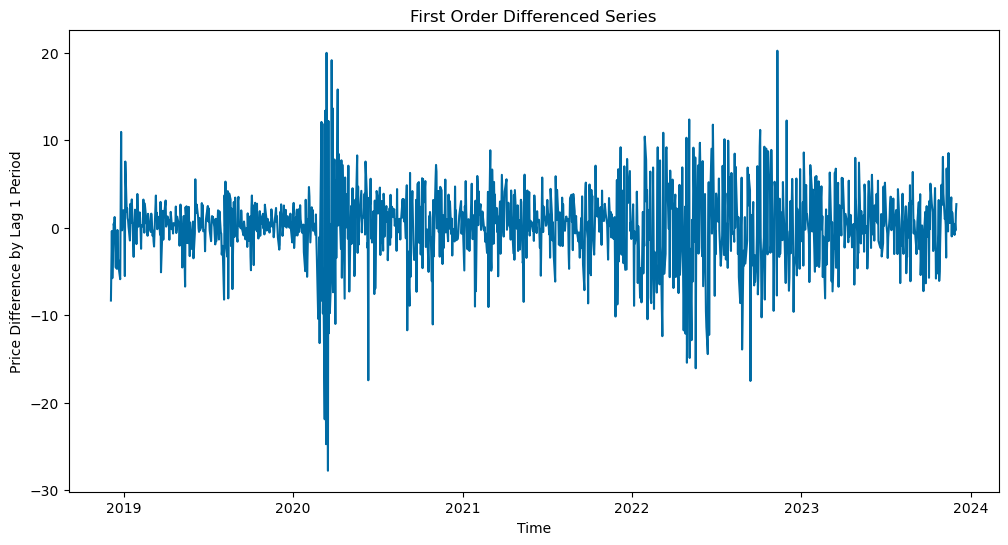

In [8]:
X['lag_1'] = X.diff() # periods=1 by default
X['lag_14'] = X.diff(periods=14) 
plt.figure(figsize=(12,6))
plt.plot(X['lag_1'])
plt.title('First Order Differenced Series')
plt.xlabel('Time')
plt.ylabel('Price Difference by Lag 1 Period')
plt.show()

### X['lag_1'], therefore, is the first-ordered differenced stationary series to use.

In [9]:
ts_lag_1 = X.lag_1.dropna()
ts_lag_14 = X.lag_14.dropna()
result = adfuller(ts_lag_1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])

ADF Statistic: -10.964829
p-value: 0.000000
Critical Values:
{'1%': -3.4356006420838963, '5%': -2.8638586845641063, '10%': -2.5680044958343604}


(ADF) P-value < .05; therefore, AAPL price series is a difference-stationary series.

### Smoothing Methods
##### Reference
https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/

### Triple Exponential Smoothing
##### Use because we assume these time series have level, trends, seasonality, and noise
##### https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/

In [10]:
# Using method from Brownlee, J. (2020).
def exp_smoothing_forecast(history, config):
    t,d,s,p,b,r = config
    # define model model
    history = array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    # fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

## Time Series Prediction
### Data partition
#### 2 years train; last 1 year validation

In [11]:
ts_lag_1 = ts_lag_1.asfreq('D')
ts_lag_1 = ts_lag_1.ffill()

past_year = ts_lag_1.iloc[-252:] # Typically 252 trading days per year
before_past_year = ts_lag_1.iloc[:-len(past_year)] # Beginning of selected time series until before 'past_year'

In [12]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]
close_valid = close.iloc[-252:]

## Simple Exponential forecaster
### Plot an initial time series
##### Reference: Module 1

In [13]:
# Forecast 12 months ahead
ses_model = SimpleExpSmoothing(close_train).fit()

ses_pred = ses_model.forecast(steps=len(close_valid))
print('AIC = %s' %(ses_model.aic))
print('BIC = %s' %(ses_model.bic))
ses_eval_metrics = ts_eval_metrics(close_valid, ses_pred)

AIC = 3052.9047478966068
BIC = 3062.732222597926
Time Series Evaluation Metrics
MSE = 884.7220333918478
MAE = 24.47048795245744
RMSE = 29.74427732172775
MAPE = 0.05673055246343077
r2 = -0.6403084418412743



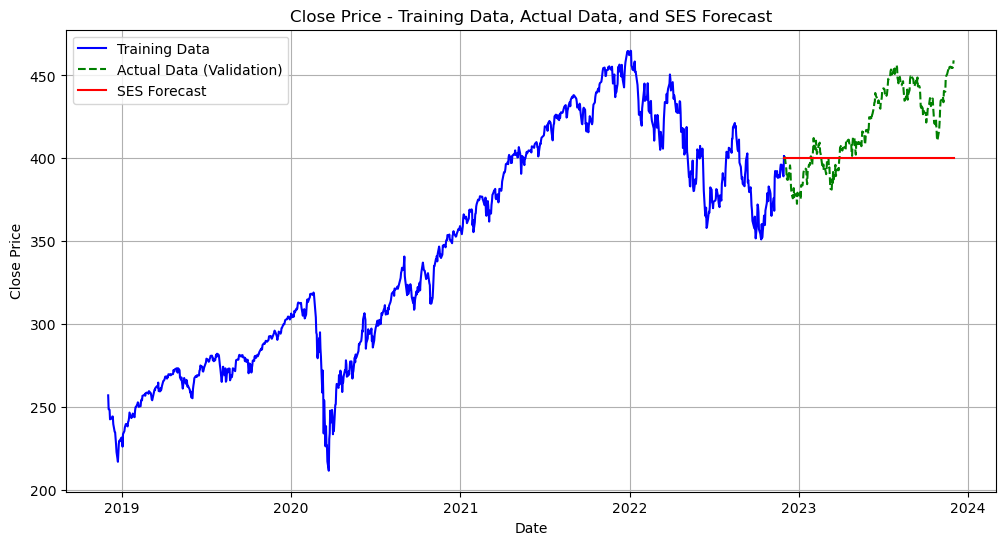

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, ses_pred, label='SES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and SES Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
#### WORKING IN PROGRESS to be investigate ######

# #impute
close = close.asfreq('D')
close = close.ffill()

## Decomposition of Raw Values

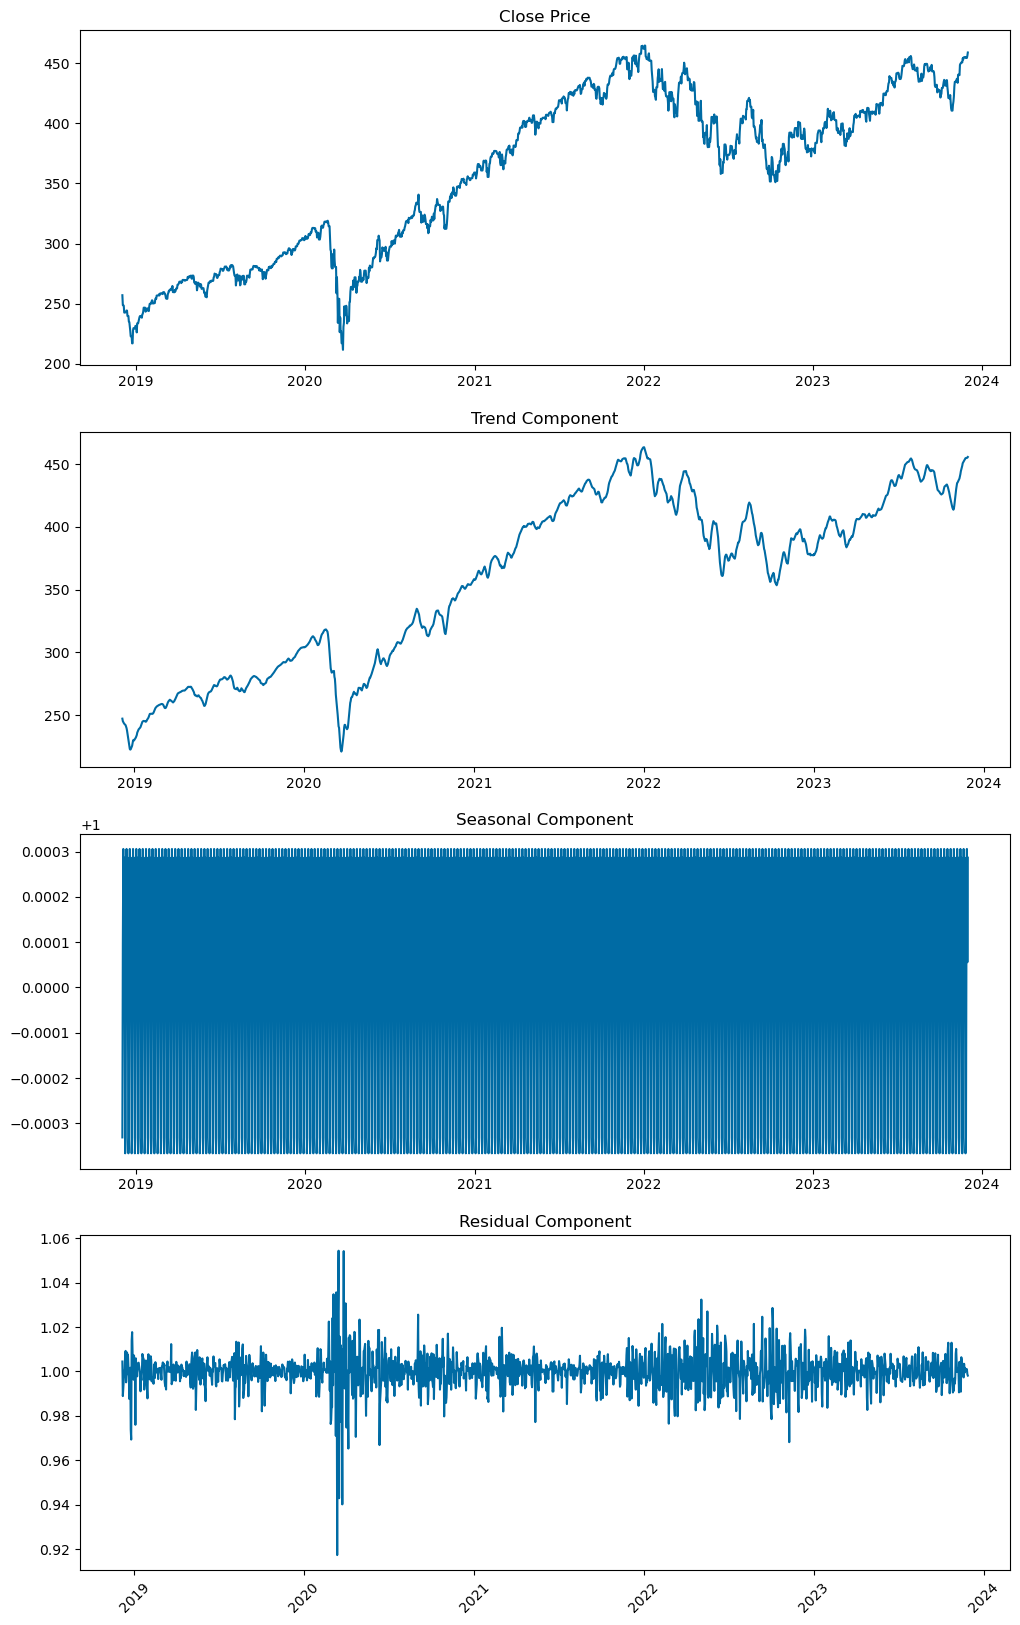

In [16]:
decomposition = seasonal_decompose(close, model='multiplicative')
#decomposition.plot()

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, axs = plt.subplots(4)
fig.set_figheight(20)
fig.set_figwidth(12)
plt.xticks(rotation=45)
axs[0].title.set_text('Close Price')
axs[1].title.set_text('Trend Component')
axs[2].title.set_text('Seasonal Component')
axs[3].title.set_text('Residual Component')
axs[0].plot(close)
axs[1].plot(trend)
axs[2].plot(seasonal)
axs[3].plot(residual)

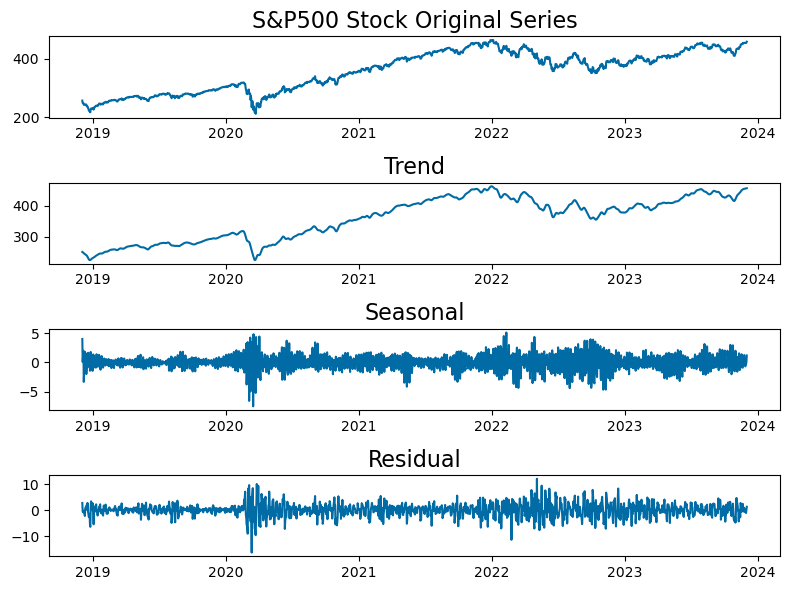

In [17]:
stl_close = STL(close)
stl_close_f = stl_close.fit()


# Plot decomposition:

plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(close)
plt.title('S&P500 Stock Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(stl_close_f.trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(stl_close_f.seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(stl_close_f.resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

### Anomaly Detection from STL Decomposition

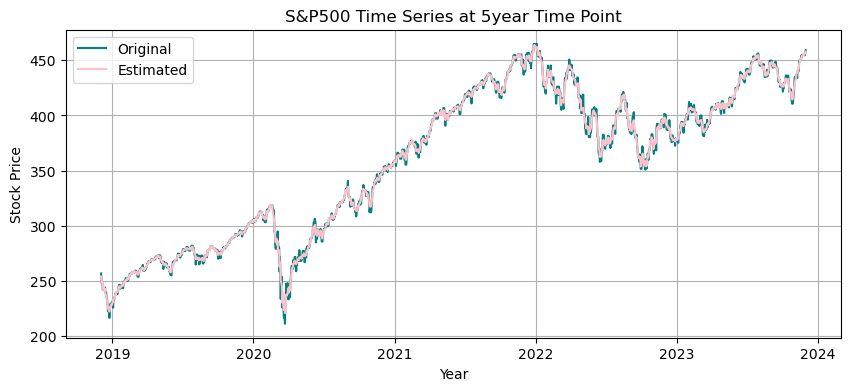

In [18]:
estimated0 = stl_close_f.trend + stl_close_f.seasonal
plt.figure(figsize=(10,4))
plt.plot(close, label='Original', color = 'teal')
plt.plot(estimated0, label ='Estimated', color = 'pink')


plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.title('S&P500 Time Series at 5year Time Point')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Taking residuals and detecting anomaly at 3std. dev: 

resid_mu0 = stl_close_f.resid.mean()
resid_dev0 = stl_close_f.resid.std()

lower0 = resid_mu0 - 3*resid_dev0
upper0 = resid_mu0 + 3*resid_dev0

Text(0.5, 1.0, 'S&P500 at 5year Time Point')

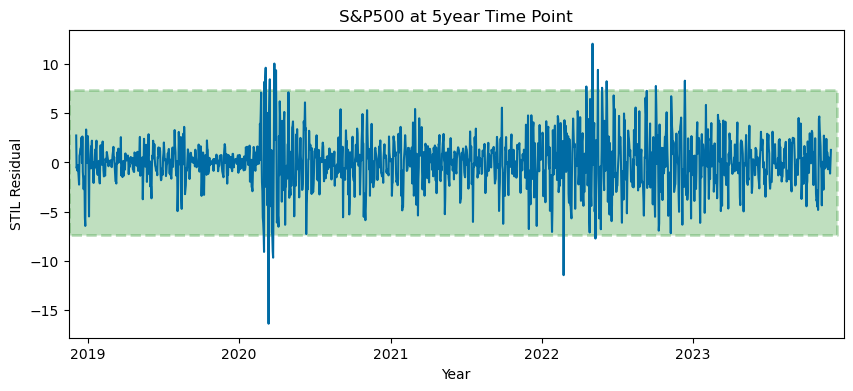

In [20]:
# Plot residual threshold: 

plt.figure(figsize=(10,4))
plt.plot(stl_close_f.resid)

plt.fill_between([datetime(2018,11,15), datetime(2023,12,15)], lower0, upper0, color='g', alpha=0.25, linestyle='--', linewidth=2)
plt.xlim(datetime(2018,11,15), datetime(2024,1,1))

plt.xlabel('Year')
plt.ylabel('STIL Residual')
plt.title('S&P500 at 5year Time Point')

In [21]:
# Identify anomalies by setting the residuals upper and lower limits:

anomalies0 = close[(stl_close_f.resid < lower0) | (stl_close_f.resid > upper0)]
anomalies0 = pd.DataFrame(anomalies0)

Text(0.5, 1.0, 'S&P500: Anomalies Marked at 3 Std. Dev or 99.7% within Normal Distribution ')

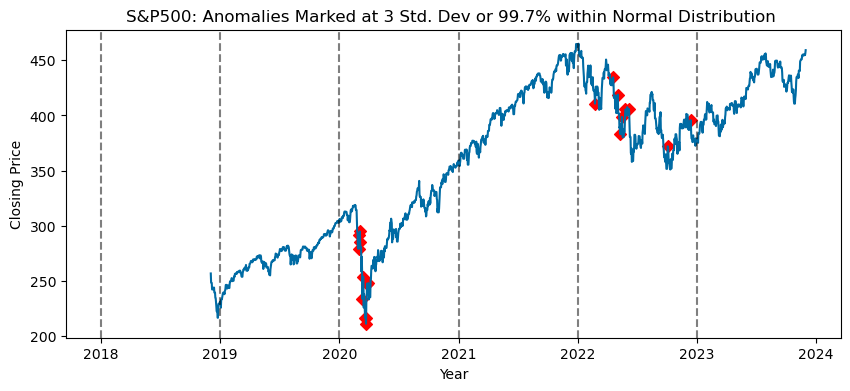

In [22]:
# Plot identified residual anomalies:    

plt.figure(figsize=(10,4))
plt.plot(close)

for year in range(2018,2024):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)
    
plt.scatter(anomalies0.index, anomalies0.Close, color='r', marker='D')
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.title('S&P500: Anomalies Marked at 3 Std. Dev or 99.7% within Normal Distribution ')

In [23]:
# Anomalies identified outside 3std dev of residuals: 

anomalies0.head()

Close
Date                                 
2020-03-01 00:00:00-05:00  279.321106
2020-03-02 00:00:00-05:00  291.417511
2020-03-04 00:00:00-05:00  294.971893
2020-03-05 00:00:00-05:00  285.166534
2020-03-12 00:00:00-04:00  233.924103

### Gather parameters from decomposition

In [24]:
stl_close.config, stl_close.period

({'period': 7,
  'seasonal': 7,
  'seasonal_deg': 1,
  'seasonal_jump': 1,
  'trend': 15,
  'trend_deg': 1,
  'trend_jump': 1,
  'low_pass': 9,
  'low_pass_deg': 1,
  'low_pass_jump': 1,
  'robust': False},
 7)

## TO DO
### 1. Fit models to TREND and SEASON components
### 2. Make predictions with steps=len(close_valid) for each
### 3. Add these predictions to ARIMA predictions for FINAL prediction (sum of all components)

In [25]:
# Trend model for trend time series 'trend' from Blk 16 above
# <code here>

# Season model for seasonal time series 'seasonal' from Blk 16 above
# <code here>

# Make predictions for each to be added to the ARIMA residual predictions
# <code here>

### Autocorrelation - Raw Values

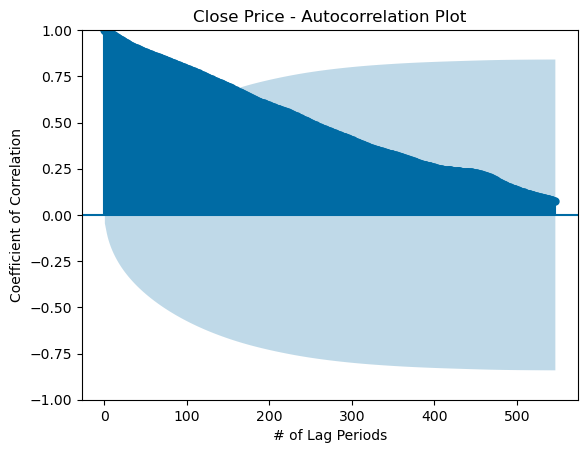

In [26]:
plot_acf(close, lags=546)  # Adjust the number of lags as needed
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Autocorrelation Plot')
plt.show()

### Partial Autocorrelation Plot - Raw Values

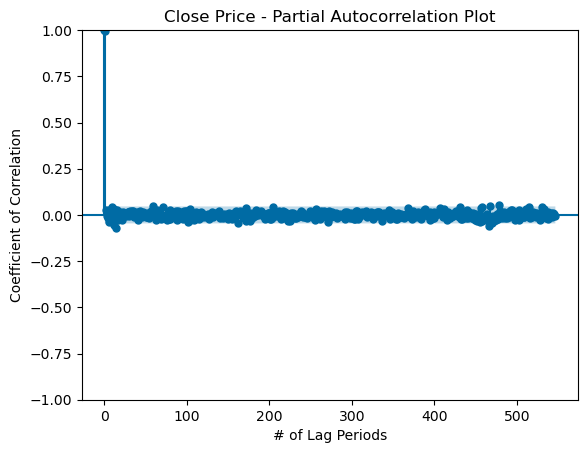

In [27]:
plot_pacf(close, lags=546)
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Partial Autocorrelation Plot')
plt.show()

### Therefore, based on PACF plot, we may want to do AR model with lags 1, 2 ~415, ~485, ~510.

## Lag_1 Decomposition

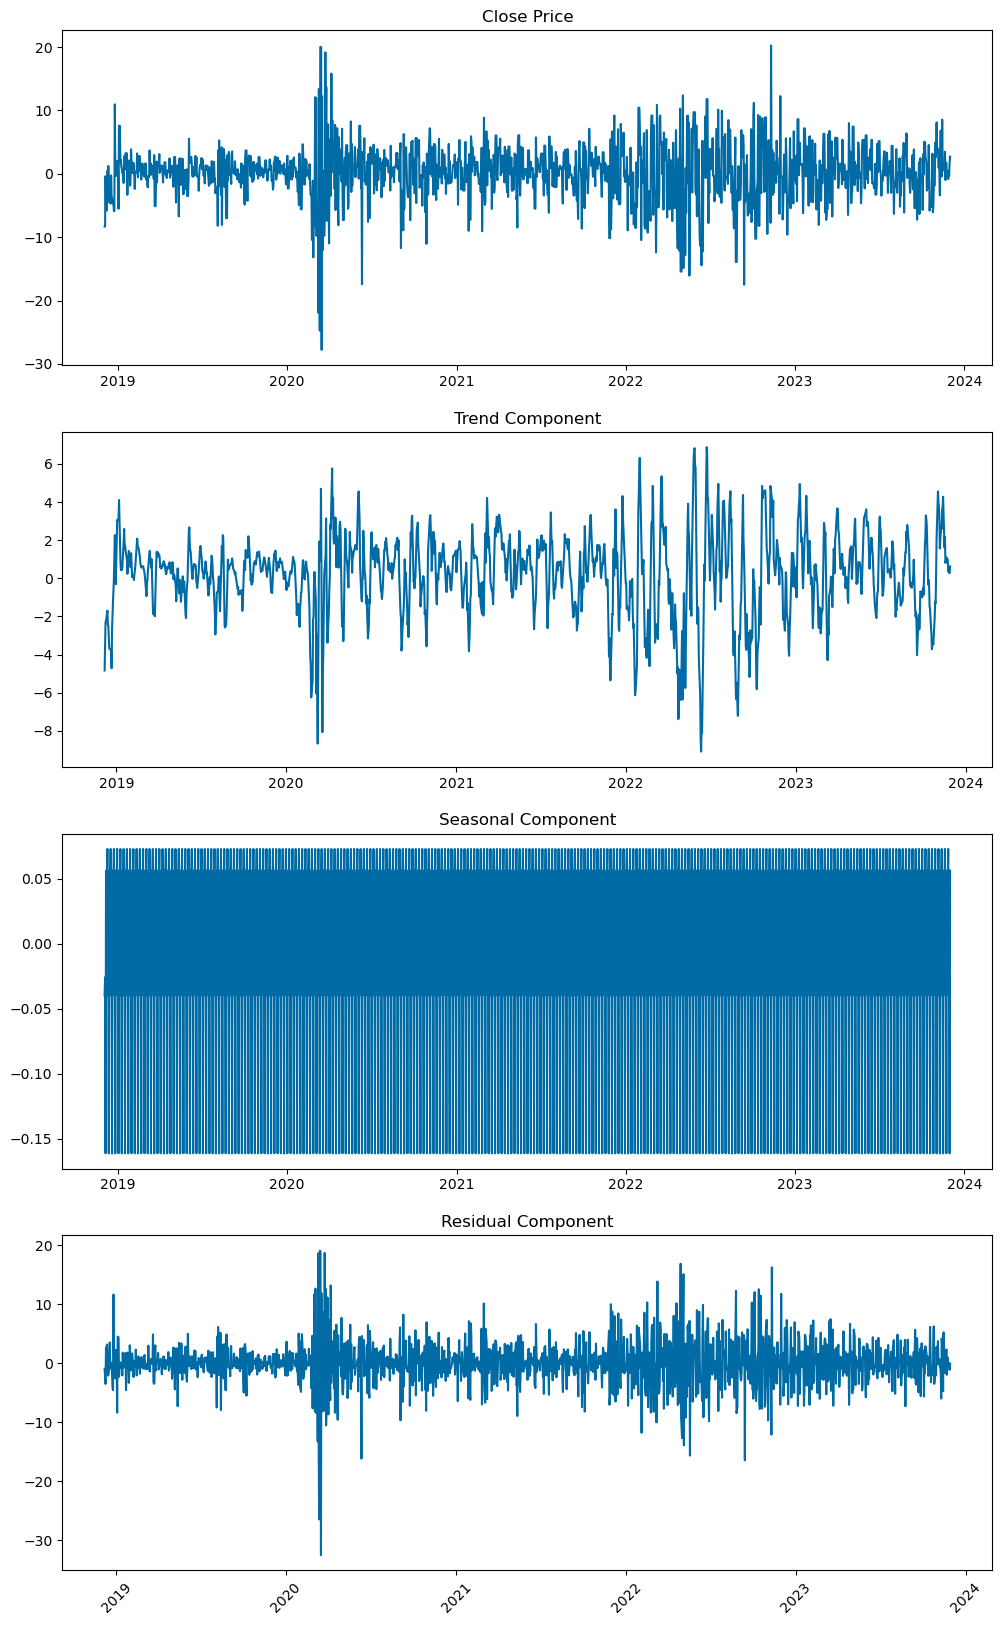

In [28]:
decomposition_lag_1 = seasonal_decompose(ts_lag_1, model='additive')
#decomposition.plot()

trend_lag_1 = decomposition_lag_1.trend
seasonal_lag_1 = decomposition_lag_1.seasonal
residual_lag_1 = decomposition_lag_1.resid

fig, axs = plt.subplots(4)
fig.set_figheight(20)
fig.set_figwidth(12)
plt.xticks(rotation=45)
axs[0].title.set_text('Close Price')
axs[1].title.set_text('Trend Component')
axs[2].title.set_text('Seasonal Component')
axs[3].title.set_text('Residual Component')
axs[0].plot(ts_lag_1)
axs[1].plot(trend_lag_1)
axs[2].plot(seasonal_lag_1)
axs[3].plot(residual_lag_1)

### Decompose using STL

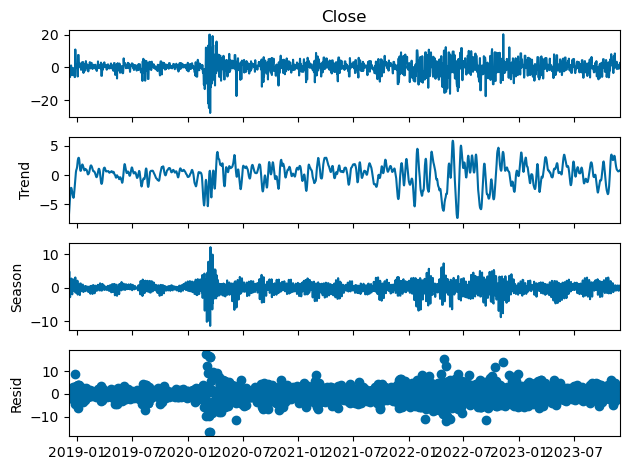

In [29]:
stl = STL(ts_lag_1)
stl_plot = stl.fit().plot()

In [30]:
stl.config, stl.period

({'period': 7,
  'seasonal': 7,
  'seasonal_deg': 1,
  'seasonal_jump': 1,
  'trend': 15,
  'trend_deg': 1,
  'trend_jump': 1,
  'low_pass': 9,
  'low_pass_deg': 1,
  'low_pass_jump': 1,
  'robust': False},
 7)

# ARIMA Parameter Selection
##### Reference: Shmueli, G. (2016). ARIMA models [Youtube Video]. https://www.youtube.com/watch?v=0xHf-SJ9Z9U&list=PLoK4oIB1jeK0LHLbZW3DTT05e4srDYxFq&index=29

### ACF on lag_1 period

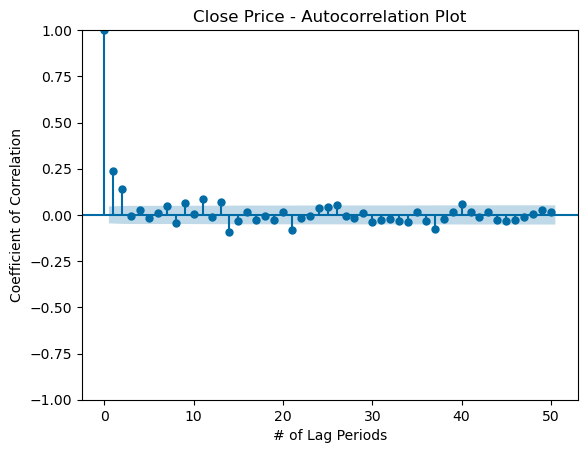

In [31]:
plot_acf(ts_lag_1, lags=50)  # Adjust the number of lags as needed
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Autocorrelation Plot')
plt.show()

### Therefore, based on ACF plot, we may want to do MA at 0, 1, 2, 11, 13, 14, 21, 37, 40.

### Plot PACF on lag_1 period

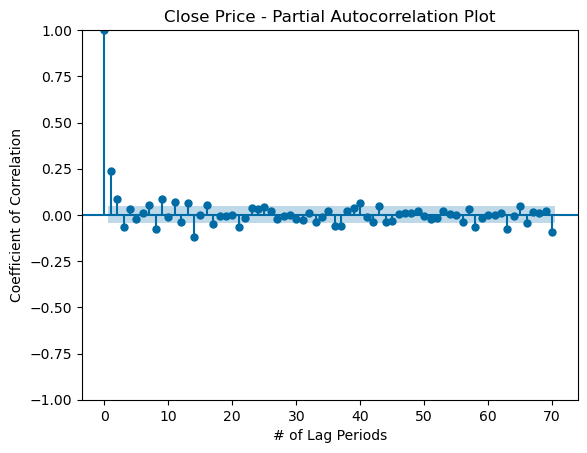

In [32]:
plot_pacf(ts_lag_1, lags=70)
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Partial Autocorrelation Plot')
plt.show()

### Therefore, based on PACF plot, we may want to do AR at 1, 2, 3, 8, 9, 11, 14, and 21, 58, 63, 70.

In [33]:
# Reference: ritvikmath (2020, Oct 7). Time series model selection (AIC & BIC): Time series talk [YouTube]. 
# https://www.youtube.com/watch?v=McEN54l3EPU

ar_orders = [1, 2, 3, 8, 9, 11, 14, 21]#, 58, 63]#, 70] # based on PACF
#ar_orders = [58, 63]#, 70] # based on PACF # attempting higher order from PACF
ma_orders = [1, 2, 11, 13, 14, 21] # based on ACF
fitted_model_dict = {}
for i, ar_order in enumerate(ar_orders):
    ar_model = sm.tsa.arima.ARIMA(ts_lag_1, order=(ar_order,1,1),trend='n') #import statsmodels.api as sm for ARIMA
    ar_model_fit = ar_model.fit()
    fitted_model_dict[ar_order] = ar_model_fit
for ar_order in ar_orders:
    print('AIC for AR(%s): %s' %(ar_order, fitted_model_dict[ar_order].aic))
    print('BIC for AR(%s): %s' %(ar_order, fitted_model_dict[ar_order].bic))
    print('\n')
    

AIC for AR(1): 10444.921083254842
BIC for AR(1): 10461.445799578878


AIC for AR(2): 10432.801760792845
BIC for AR(2): 10454.83471589156


AIC for AR(3): 10427.538268571261
BIC for AR(3): 10455.079462444655


AIC for AR(8): 10418.975719886814
BIC for AR(8): 10474.0581076336


AIC for AR(9): 10406.880809136233
BIC for AR(9): 10467.471435657699


AIC for AR(11): 10401.419025940777
BIC for AR(11): 10473.0261300116


AIC for AR(14): 10371.201035599393
BIC for AR(14): 10459.332855994253


AIC for AR(21): 10369.03624470796
BIC for AR(21): 10495.72573652557




### Select AR(14) due to lowest AIC and BIC

### Rerun with AR(14) as default and iterate through different MA orders based on ACF

In [34]:
# Reference: ritvikmath (2020, Oct 7). Time series model selection (AIC & BIC): Time series talk [YouTube]. 
# https://www.youtube.com/watch?v=McEN54l3EPU

#ar_orders = [1, 2, 3, 8, 9, 11, 14, 21]
ar_orders = [0, 1, 2, 11, 13, 14, 21, 37, 40] #actually MA orders, but using same var name for simplicity
fitted_model_dict = {}
for i, ar_order in enumerate(ar_orders):
    ar_model = sm.tsa.arima.ARIMA(ts_lag_1, order=(14,1,ar_order)) #import statsmodels.api as sm for ARIMA
    ar_model_fit = ar_model.fit()
    fitted_model_dict[ar_order] = ar_model_fit
for ar_order in ar_orders:
    print('AIC for MA(%s): %s' %(ar_order, fitted_model_dict[ar_order].aic))
    print('BIC for MA(%s): %s' %(ar_order, fitted_model_dict[ar_order].bic))
    print('\n')
    

AIC for MA(0): 10473.038458157942
BIC for MA(0): 10555.662039778123


AIC for MA(1): 10371.201035599393
BIC for MA(1): 10459.332855994253


AIC for MA(2): 10400.469392150822
BIC for MA(2): 10494.109451320359


AIC for MA(11): 10362.510529388308
BIC for MA(11): 10505.724737529954


AIC for MA(13): 10364.694480820104
BIC for MA(13): 10518.925166511106


AIC for MA(14): 10361.847586505988
BIC for MA(14): 10521.586510971669


AIC for MA(21): 10365.288939659134
BIC for MA(21): 10563.585535547567


AIC for MA(37): 10354.28786681423
BIC for MA(37): 10640.71628309752


AIC for MA(40): 10357.661225730088
BIC for MA(40): 10660.614358337414




### AIC and BIC minimization suggest order=(14,1,1) is the optimal 3-tuple

### Measure error statistics on validation set

In [35]:
arima_model = sm.tsa.arima.ARIMA(ts_lag_1, order=(14,1,1)).fit() #import statsmodels.api as sm for ARIMA
print('AIC = %s' %(arima_model.aic))
print('BIC = %s' %(arima_model.bic))
arima_pred = arima_model.forecast(steps=len(close_valid))
arima_metrics = ts_eval_metrics(close_valid, arima_pred)

AIC = 10371.201035599393
BIC = 10459.332855994253
Time Series Evaluation Metrics
MSE = 175743.52264651892
MAE = 418.573826951311
RMSE = 419.2177508724063
MAPE = 0.9995122900774612
r2 = -324.83520350547246



### Interpretation: Even with minimum AIC and BIC, ARIMA optimal pdq based on ACF and PACF performs very poorly

## Attempt: Find optimal AES model parameters

In [36]:
#close_train = pd.DataFrame(close_train)
#close_train.reset_index(inplace=True)

In [37]:
#close_train.index

In [38]:
# Reference: https://www.statsmodels.org/stable/generated/
# statsmodels.tsa.holtwinters.ExponentialSmoothing.html#statsmodels.tsa.holtwinters.ExponentialSmoothing

aes_param_trend = ['add', 'mul', 'additive', 'multiplicative', None]
aes_param_damped_trend = [True, False]
aes_param_seasonal = ['add', 'mul', 'additive', 'multiplicative', None]
aes_param_seasonal_periods = [2, 3, 8, 9, 11, 14, 21, 58, 59, 60, 61, 62, 63, 64, 65, 70] # Informed by PACF
aes_param_initial_method = [None, 'estimated', 'heuristic', 'legacy-heuristic']

fit_param_smoothing_level = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_param_smoothing_trend = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_param_smoothing_seasonal = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_param_damping_trend = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_optimzied = [True, False]
fit_method = ['L-BFGS-B', 'TNC', 'SLSQP', 'Powell', 'trust-constr', 'least_square']

fitted_model_dict = {}

### Searching for ideal seasonal period parameter

In [39]:
for i in aes_param_seasonal_periods:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=True, #True, False
                                     seasonal= 'mul', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= i, 
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Seasonal Period %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)


Results for Seasonal Period 2
AIC = 3551.0366029897004
BIC = 3585.4327644443183
Time Series Evaluation Metrics
MSE = 1260.5385327425504
MAE = 29.204323756221708
RMSE = 35.50406360886807
MAPE = 0.06739966345894247
r2 = -1.3370865859379322

Results for Seasonal Period 3
AIC = 3858.867925931538
BIC = 3898.1778247368156
Time Series Evaluation Metrics
MSE = 1167.8929000533503
MAE = 27.95606778148767
RMSE = 34.17444805777191
MAPE = 0.06453060369249226
r2 = -1.1653180443348616

Results for Seasonal Period 8
AIC = 4436.505197507385
BIC = 4500.38378306596
Time Series Evaluation Metrics
MSE = 1787.7140497632352
MAE = 40.042067302949334
RMSE = 42.28136764300837
MAPE = 0.09604563961517054
r2 = -2.3144901299480924

Results for Seasonal Period 9
AIC = 4455.007974177193
BIC = 4523.800297086429
Time Series Evaluation Metrics
MSE = 1939.1733382023374
MAE = 41.681848037408145
RMSE = 44.036045896541815
MAPE = 0.09989103236038525
r2 = -2.5953014356973827

Results for Seasonal Period 11
AIC = 4364.09747520

### Seasonal Periods at 2, 3, and 60 appear to be locally optimal candidate parameter values, but accounting for AIC and BIC, Seasonal Period 2 or 3 may be ideal.

### Searching for ideal seasonal parameter

In [40]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_seasonal:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=False, #True, False
                                     seasonal= i, # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3, 
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Seasonal %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)


Results for Seasonal add
AIC = 3900.1713468427993
BIC = 3934.567508297417
Time Series Evaluation Metrics
MSE = 1077.3643735372111
MAE = 27.66551485545325
RMSE = 32.823229175954204
MAPE = 0.06573607899077656
r2 = -0.9974746984394556

Results for Seasonal mul
AIC = 3898.481923814169
BIC = 3932.878085268787
Time Series Evaluation Metrics
MSE = 1211.3482289288881
MAE = 29.502191363620216
RMSE = 34.80442829481456
MAPE = 0.0700149063988041
r2 = -1.2458858838451534

Results for Seasonal additive
AIC = 3900.1713468427993
BIC = 3934.567508297417
Time Series Evaluation Metrics
MSE = 1077.3643735372111
MAE = 27.66551485545325
RMSE = 32.823229175954204
MAPE = 0.06573607899077656
r2 = -0.9974746984394556

Results for Seasonal multiplicative
AIC = 3898.481923814169
BIC = 3932.878085268787
Time Series Evaluation Metrics
MSE = 1211.3482289288881
MAE = 29.502191363620216
RMSE = 34.80442829481456
MAPE = 0.0700149063988041
r2 = -1.2458858838451534

Results for Seasonal None
AIC = 4647.261634975134
BIC = 

### Validation statistics suggest additive seasonality is optimal

### Searching for ideal trend parameter

In [41]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_trend:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend=i, # 'add', 'mul', 'additive', 'multiplicative', None
                                     #damped_trend=True, #True, False
                                     seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3, 
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Trend %s' % (i))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)

Results for Trend add
AIC = 3904.605316670274
BIC = 3939.001478124892
Time Series Evaluation Metrics
MSE = 581.2848298837604
MAE = 20.024142236250817
RMSE = 24.109849229801508
MAPE = 0.04803358492997536
r2 = -0.07772427676196147

Results for Trend mul
AIC = 3900.171255117832
BIC = 3934.56741657245
Time Series Evaluation Metrics
MSE = 1077.3665594958177
MAE = 27.66554609223045
RMSE = 32.823262474894506
MAPE = 0.06573615174422748
r2 = -0.997478751290205

Results for Trend additive
AIC = 3904.605316670274
BIC = 3939.001478124892
Time Series Evaluation Metrics
MSE = 581.2848298837604
MAE = 20.024142236250817
RMSE = 24.109849229801508
MAPE = 0.04803358492997536
r2 = -0.07772427676196147

Results for Trend multiplicative
AIC = 3900.171255117832
BIC = 3934.56741657245
Time Series Evaluation Metrics
MSE = 1077.3665594958177
MAE = 27.66554609223045
RMSE = 32.823262474894506
MAPE = 0.06573615174422748
r2 = -0.997478751290205

Results for Trend None
AIC = 3876.6410857892342
BIC = 3901.20977254253

### Validation statistics suggest multiplicative trend is optimal

### Searching for ideal aes_param_damped_trend parameter

In [42]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_damped_trend:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=i, #True, False
                                     seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3, 
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Damped Trend %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)

Results for Damped Trend True
AIC = 3889.8838778045083
BIC = 3929.193776609786
Time Series Evaluation Metrics
MSE = 245.8332366209703
MAE = 13.348502371071325
RMSE = 15.679070017732885
MAPE = 0.031817903036625524
r2 = 0.5442157897112719

Results for Damped Trend False
AIC = 3900.1707855701707
BIC = 3934.5669470247885
Time Series Evaluation Metrics
MSE = 1077.364244451415
MAE = 27.66551338500804
RMSE = 32.823227209575464
MAPE = 0.06573607602422384
r2 = -0.9974744591094595



### Validation statistics suggest trend should be damped.

### Searching for optimal initialization method

In [43]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_initial_method:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend='add', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=False, #True, False
                                     seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3, 
                                     initialization_method=i
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Initialization Method %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)

Results for Initialization Method None
AIC = 3919.514758681978
BIC = 3953.910920136596
Time Series Evaluation Metrics
MSE = 550.8558818291018
MAE = 19.43496208715689
RMSE = 23.470319167601915
MAPE = 0.04665029043541389
r2 = -0.021307844835823042

Results for Initialization Method estimated
AIC = 3898.5914460274425
BIC = 3932.9876074820604
Time Series Evaluation Metrics
MSE = 583.1762238808725
MAE = 20.06016214445025
RMSE = 24.14904188328954
MAPE = 0.04811813231877655
r2 = -0.08123099347434692

Results for Initialization Method heuristic
AIC = 3904.6054307653003
BIC = 3939.001592219918
Time Series Evaluation Metrics
MSE = 581.2840995613557
MAE = 20.02412832816456
RMSE = 24.109834084069423
MAPE = 0.048033552289560036
r2 = -0.0777229227163283

Results for Initialization Method legacy-heuristic
AIC = 3919.514758681978
BIC = 3953.910920136596
Time Series Evaluation Metrics
MSE = 550.8558818291018
MAE = 19.43496208715689
RMSE = 23.470319167601915
MAPE = 0.04665029043541389
r2 = -0.0213078448

### Validation statistics suggest initialization should be heuristic.

### Final pre-fit Advanced Exponential Smoothing Model w/ Parameters

In [44]:
aes_model = ExponentialSmoothing(close_train, 
                                 trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                 damped_trend=True, #True, False
                                 seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                 seasonal_periods= 3, 
                                 initialization_method='heuristic') #'estimated', 'heuristic', 'legacy-heuristic'

aes_model = aes_model.fit(smoothing_level=.1, 
                          smoothing_trend=.1,
                          #smoothing_seasonal=.1,
                          #damping_trend=.002
                         )

aes_pred = aes_model.forecast(steps=len(close_valid))
print('AIC = %s' %(aes_model.aic))
print('BIC = %s' %(aes_model.bic))
aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)
print(aes_eval_metrics)

AIC = 3889.8844447164233
BIC = 3929.194343521701
Time Series Evaluation Metrics
MSE = 245.83311375353708
MAE = 13.348499461121747
RMSE = 15.679066099533387
MAPE = 0.0318178959934443
r2 = 0.5442160175121861

None


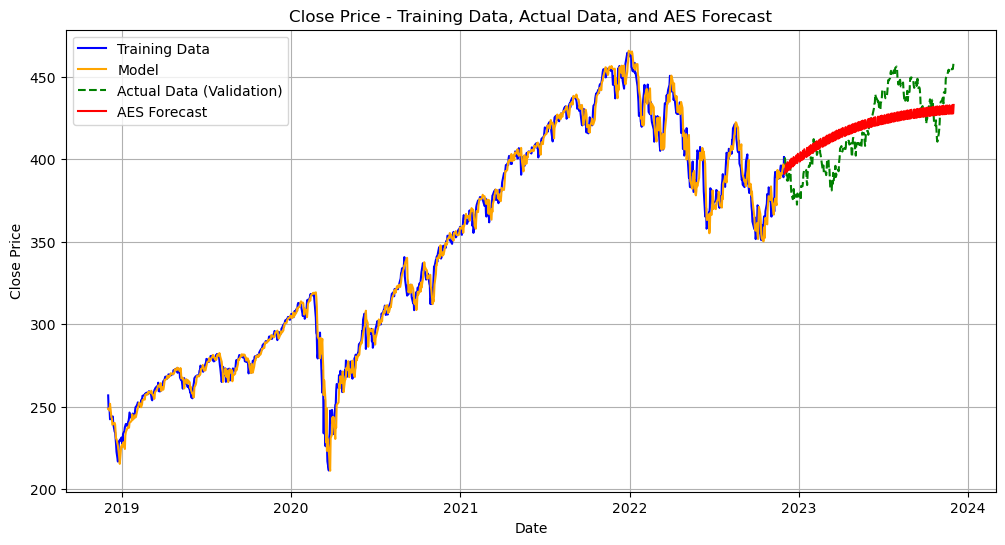

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(aes_model.fittedvalues, label="Model", color = 'orange')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, aes_pred, label='AES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and AES Forecast')
plt.legend()
plt.grid(True)
plt.show()

### Replicate the above, but with seasonal_periods=2 for lower AIC and BIC

In [46]:
aes_model = ExponentialSmoothing(close_train, 
                                 trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                 damped_trend=True, #True, False
                                 seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                 seasonal_periods= 2, 
                                 initialization_method='heuristic') #'estimated', 'heuristic', 'legacy-heuristic'

aes_model = aes_model.fit(smoothing_level=.1, 
                          smoothing_trend=.1,
                          #smoothing_seasonal=.1,
                          #damping_trend=.002
                         )

aes_pred = aes_model.forecast(steps=len(close_valid))
print('AIC = %s' %(aes_model.aic))
print('BIC = %s' %(aes_model.bic))
aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)
print(aes_eval_metrics)

AIC = 3567.9813301684812
BIC = 3602.377491623099
Time Series Evaluation Metrics
MSE = 416.2555852877353
MAE = 16.232853534804764
RMSE = 20.402342642151055
MAPE = 0.037723347240277316
r2 = 0.22824624600635135

None


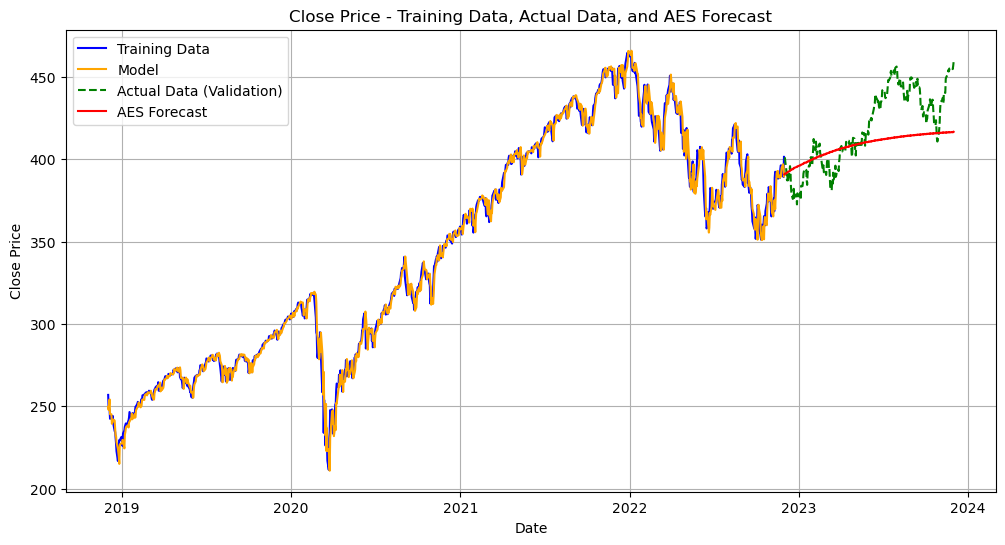

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(aes_model.fittedvalues, label="Model", color = 'orange')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, aes_pred, label='AES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and AES Forecast')
plt.legend()
plt.grid(True)
plt.show()

## Autoregression Integrated Moving Average (ARIMA)
##### Reference:
##### Brownlee, J. (2020). How to create an ARIMA model for time series forecasting in Python. Machine Learning Mastery. https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python

In [48]:
# Auto regression integrated moving average; Find best (p,d,q) by using auto_arima function
# p = number of lag observations, lag order
# d = number of raw observations differenced, degree of differencing
# q = size of moving average window, order of moving average
# auto_arima_model = auto_arima(close_train, d=2, seasonal=True, stepwise=True, trace=True)
# auto_arima_model.summary()
# arima_pred = auto_arima_model.predict(n_periods=len(close_valid))
close_train = close_train.asfreq('D')
arima_model = sm.tsa.ARIMA(close_train, order=(14,1,1)).fit() #use '2' for quadratic trend
print(arima_model.summary())
arima_pred = arima_model.forecast(steps=len(close_valid))

# TO DO: ADD TREND AND SEASONAL FORECASTS TO ARIMA FORECAST (RESIDUAL COMPONENT) FOR FINAL FORECAST

# arima_eval_metrics = ts_eval_metrics(close_valid, arima_pred)
# print(arima_eval_metrics)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1459
Model:                ARIMA(14, 1, 1)   Log Likelihood               -2944.213
Date:                Sat, 02 Dec 2023   AIC                           5920.427
Time:                        16:05:01   BIC                           6004.984
Sample:                    12-03-2018   HQIC                          5951.972
                         - 11-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1683      1.017     -0.165      0.869      -2.161       1.825
ar.L2         -0.1196      0.146     -0.819      0.413      -0.406       0.167
ar.L3          0.1903      0.116      1.635      0.1

In [49]:
# auto_arima_model.plot_diagnostics(figsize=(12, 8))
# arima_pred.head

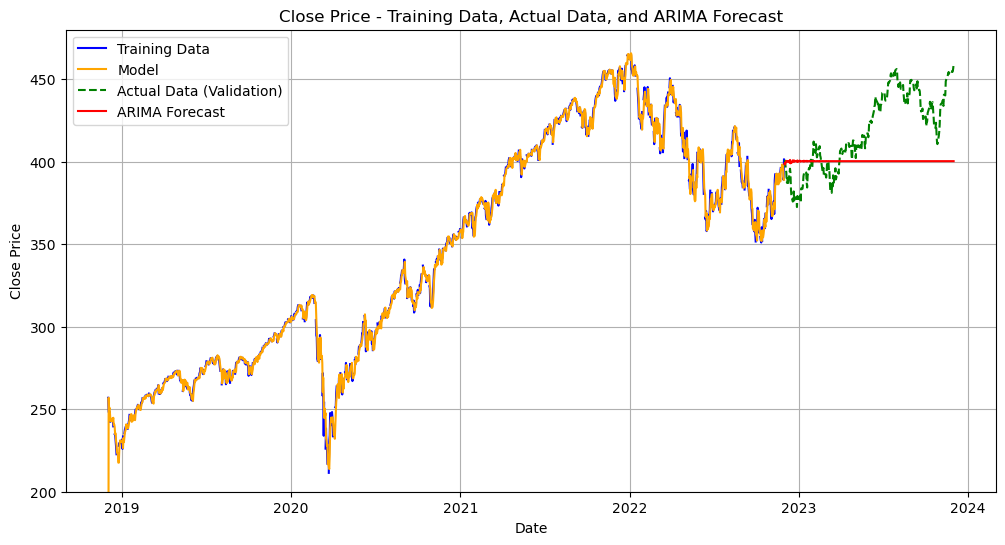

In [50]:
# plt.plot(close_valid.index, arima_pred, label="Predicted", color='red')
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.set_ylim([200, 480])
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(arima_model.fittedvalues, label="Model", color = 'orange') # turn off it doesnt work
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, arima_pred, label='ARIMA Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()

## Logistic Regression Model on SPY

### Add fields on open-close difference

In [113]:
hist = aapl.history(period = '1y')
# # hist = hist.diff()
# hist = hist.diff(periods=15)
# hist = hist.shift(3)
# hist = hist.dropna()
# hist['open_close'] = hist['Close'] - hist['Open']
# hist['positive'] = np.where(hist['open_close'] >= 0, 1, 0)
# hist['high_low'] = hist['High'] - hist['Low']

# X = hist.drop(['positive'], axis =1)
# y = hist['positive']

# Add columns
hist['open_close'] = hist['Close'] - hist['Open']
hist['positive'] = np.where(hist['open_close'] > 0, 1, 0)
hist['high_low'] = hist['High'] - hist['Low']
hist = hist.drop(['Dividends', 'Stock Splits', 'Capital Gains'], axis=1) # Clean out sparse columns
hist.head()

Open        High         Low       Close  \
Date                                                                        
2022-12-02 00:00:00-05:00  396.015856  401.538896  395.907575  400.603638   
2022-12-05 00:00:00-05:00  397.689477  398.654269  391.999058  393.397034   
2022-12-06 00:00:00-05:00  393.229679  393.790822  385.570257  387.726288   
2022-12-07 00:00:00-05:00  386.850150  389.508317  385.895182  387.066742   
2022-12-08 00:00:00-05:00  389.016010  391.201575  387.174967  390.098938   

                             Volume  open_close  positive  high_low  
Date                                                                 
2022-12-02 00:00:00-05:00  85342700    4.587782         1  5.631322  
2022-12-05 00:00:00-05:00  77289800   -4.292443         0  6.655211  
2022-12-06 00:00:00-05:00  77972200   -5.503391         0  8.220565  
2022-12-07 00:00:00-05:00  65927900    0.216592         1  3.613135  
2022-12-08 00:00:00-05:00  60737900    1.082928         1  4.026608

In [114]:
hist['Date'] = pd.to_datetime(hist.index)
hist.insert(0, 'day_of_week', hist['Date'].dt.day_name())
hist.head()

day_of_week        Open        High         Low  \
Date                                                                        
2022-12-02 00:00:00-05:00      Friday  396.015856  401.538896  395.907575   
2022-12-05 00:00:00-05:00      Monday  397.689477  398.654269  391.999058   
2022-12-06 00:00:00-05:00     Tuesday  393.229679  393.790822  385.570257   
2022-12-07 00:00:00-05:00   Wednesday  386.850150  389.508317  385.895182   
2022-12-08 00:00:00-05:00    Thursday  389.016010  391.201575  387.174967   

                                Close    Volume  open_close  positive  \
Date                                                                    
2022-12-02 00:00:00-05:00  400.603638  85342700    4.587782         1   
2022-12-05 00:00:00-05:00  393.397034  77289800   -4.292443         0   
2022-12-06 00:00:00-05:00  387.726288  77972200   -5.503391         0   
2022-12-07 00:00:00-05:00  387.066742  65927900    0.216592         1   
2022-12-08 00:00:00-05:00  390.098938  60737900    1.082928         1   

                           high_low                      Date  
Date                                                           
2022-12-02 00:00:00-05:00  5.631322 2022-12-02 00:00:00-05:00  
2022-12-05 00:00:00-05:00  6.655211 2022-12-05 00:00:00-05:00  
2022-12-06 00:00:00-05:00  8.220565 2022-12-06 00:00:00-05:00  
2022-12-07 00:00:00-05:00  3.613135 2022-12-07 00:00:00-05:00  
2022-12-08 00:00:00-05:00  4.026608 2022-12-08 00:00:00-05:00

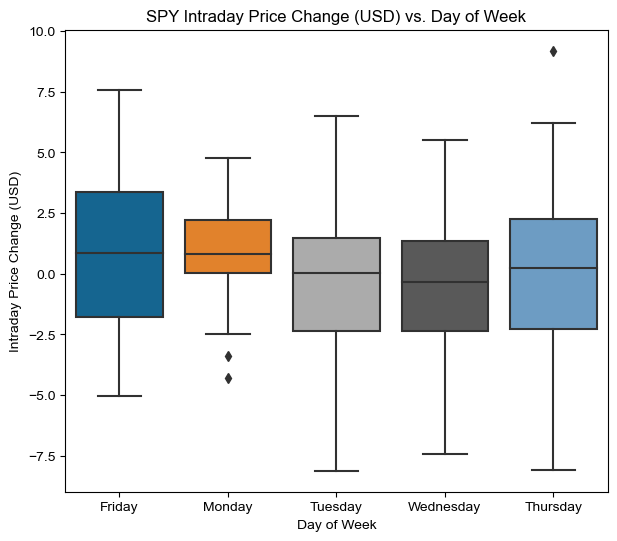

In [115]:
target_y = 'open_close'
column_x = 'day_of_week'

plt.figure(figsize=(7, 6))
sns.boxplot(x=column_x, y=target_y, data=hist)
sns.set_style("whitegrid")
plt.title("SPY Intraday Price Change (USD) vs. Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Intraday Price Change (USD)")
plt.show()

In [121]:
day_week_stats = hist.groupby('day_of_week').describe().transpose()
display(day_week_stats.loc['open_close'])

day_of_week     Friday     Monday   Thursday    Tuesday  Wednesday
count        52.000000  45.000000  51.000000  51.000000  52.000000
mean          0.759051   0.956284  -0.076981  -0.210852  -0.451133
std           3.146086   2.092741   3.717666   3.041855   2.842769
min          -5.024222  -4.292443  -8.090198  -8.122140  -7.437470
25%          -1.784516   0.039539  -2.288197  -2.382707  -2.370460
50%           0.850560   0.827100   0.239147   0.029999  -0.338245
75%           3.346358   2.220001   2.272510   1.449651   1.353934
max           7.570007   4.765015   9.187998   6.487128   5.528633

In [52]:
hist_lag = hist.copy()

lag = 3

hist_lag = hist_lag.diff(periods=lag)
#for lag in range(1, 6):
#    globals()[f'hist_lag_{lag}'] = hist_lag.diff(periods=lag)

# Inspired by Deniega, J. (2023) ADS 505 Final Project
# Add lagged columns to same index
for i in range(1, lag+1):
    for col in hist_lag.columns:
        lag_col_name = f'{col}_lag{i}'
        hist_lag[lag_col_name] = hist_lag[col].shift(i)

hist_lag = hist_lag.dropna()
#hist_lag_1 = hist_lag_1.dropna() # Remove missing values due to lags out of range
#hist_lag_2 = hist_lag_2.dropna()
#hist_lag_3 = hist_lag_3.dropna()
#hist_lag_4 = hist_lag_4.dropna()
#hist_lag_5 = hist_lag_5.dropna()

In [53]:
pd.set_option('display.max_columns', 70)
display(hist_lag.head())
#display(hist_lag_1.head())
#display(hist_lag_2.head())
#display(hist_lag_3.head())

Open       High        Low      Close  \
Date                                                                    
2022-12-15 00:00:00-05:00   0.187084  -3.642642  -5.434413  -9.175537   
2022-12-16 00:00:00-05:00 -22.910624 -21.791803 -16.027973 -16.677521   
2022-12-19 00:00:00-05:00 -16.125264 -19.608827 -16.040446 -17.361664   
2022-12-20 00:00:00-05:00 -13.121983 -11.090204  -8.176210  -7.228760   
2022-12-21 00:00:00-05:00  -1.908814   0.820898   1.631873   2.927521   

                               Volume  open_close  positive  high_low  \
Date                                                                    
2022-12-15 00:00:00-05:00  42300100.0   -9.362621      -1.0  1.791771   
2022-12-16 00:00:00-05:00  -3924500.0    6.233103       0.0 -5.763831   
2022-12-19 00:00:00-05:00 -28233200.0   -1.236399       0.0 -3.568380   
2022-12-20 00:00:00-05:00 -43278700.0    5.893224       1.0 -2.913995   
2022-12-21 00:00:00-05:00 -41690600.0    4.836335       1.0 -0.810976   

                           Open_lag1  High_lag1   Low_lag1  Close_lag1  \
Date                                                                     
2022-12-15 00:00:00-05:00   6.566610   7.757879   3.111030    6.025146   
2022-12-16 00:00:00-05:00   0.187084  -3.642642  -5.434413   -9.175537   
2022-12-19 00:00:00-05:00 -22.910624 -21.791803 -16.027973  -16.677521   
2022-12-20 00:00:00-05:00 -16.125264 -19.608827 -16.040446  -17.361664   
2022-12-21 00:00:00-05:00 -13.121983 -11.090204  -8.176210   -7.228760   

                           Volume_lag1  open_close_lag1  positive_lag1  \
Date                                                                     
2022-12-15 00:00:00-05:00   26663600.0        -0.541464            0.0   
2022-12-16 00:00:00-05:00   42300100.0        -9.362621           -1.0   
2022-12-19 00:00:00-05:00   -3924500.0         6.233103            0.0   
2022-12-20 00:00:00-05:00  -28233200.0        -1.236399            0.0   
2022-12-21 00:00:00-05:00  -43278700.0         5.893224            1.0   

                           high_low_lag1  Open_lag2  High_lag2   Low_lag2  \
Date                                                                        
2022-12-15 00:00:00-05:00       4.646850  14.846303  12.926543   5.710157   
2022-12-16 00:00:00-05:00       1.791771   6.566610   7.757879   3.111030   
2022-12-19 00:00:00-05:00      -5.763831   0.187084  -3.642642  -5.434413   
2022-12-20 00:00:00-05:00      -3.568380 -22.910624 -21.791803 -16.027973   
2022-12-21 00:00:00-05:00      -2.913995 -16.125264 -19.608827 -16.040446   

                           Close_lag2  Volume_lag2  open_close_lag2  \
Date                                                                  
2022-12-15 00:00:00-05:00    5.641235   63044600.0        -9.205068   
2022-12-16 00:00:00-05:00    6.025146   26663600.0        -0.541464   
2022-12-19 00:00:00-05:00   -9.175537   42300100.0        -9.362621   
2022-12-20 00:00:00-05:00  -16.677521   -3924500.0         6.233103   
2022-12-21 00:00:00-05:00  -17.361664  -28233200.0        -1.236399   

                           positive_lag2  high_low_lag2  Open_lag1_lag2  \
Date                                                                      
2022-12-15 00:00:00-05:00           -1.0       7.216386        1.151864   
2022-12-16 00:00:00-05:00            0.0       4.646850       14.846303   
2022-12-19 00:00:00-05:00           -1.0       1.791771        6.566610   
2022-12-20 00:00:00-05:00            0.0      -5.763831        0.187084   
2022-12-21 00:00:00-05:00            0.0      -3.568380      -22.910624   

                           High_lag1_lag2  Low_lag1_lag2  Close_lag1_lag2  \
Date                                                                        
2022-12-15 00:00:00-05:00        3.258712       1.417698         5.700287   
2022-12-16 00:00:00-05:00       12.926543       5.710157         5.641235   
2022-12-19 00:00:00-05:00        7.757879       3.111030         6.025146   
2022-12-20 00:00:00-0

              precision    recall  f1-score   support

           0       0.45      0.69      0.55        13
           1       0.82      0.62      0.71        29

    accuracy                           0.64        42
   macro avg       0.63      0.66      0.63        42
weighted avg       0.70      0.64      0.66        42



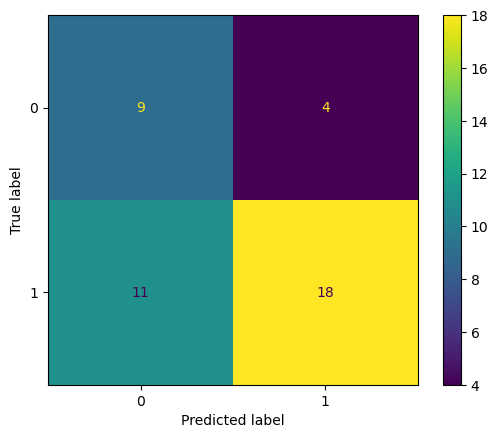

In [54]:
## Change n to lag the data
#for n in range(1, 6):  

# Data partition
y = hist['positive'] # binary values should not be differenced]['positive'] # binary values should not be differenced
X = hist_lag.drop(['positive'], axis=1)
y = y.reindex(X.index)

end_train_index = 200
X_train = X.iloc[:end_train_index]
X_valid = X.iloc[end_train_index:]

y_train = y.iloc[:end_train_index]
y_valid = y.iloc[end_train_index:]


# Model and fitting
logreg_model = LogisticRegression()
logreg_model.fit(X_train,y_train)

# Model Performance  
logreg_pred = logreg_model.predict(X_valid) 
logreg_pred = pd.Series(logreg_pred, index=X_valid.index)
y_valid = y_valid.reindex(logreg_pred.index)
cm = confusion_matrix(y_valid, logreg_pred, labels=logreg_model.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg_model.classes_)
cmd.plot()
print(classification_report(y_valid, logreg_pred))

Lag = 1
              precision    recall  f1-score   support

           0       0.45      0.69      0.55        13
           1       0.82      0.62      0.71        29

    accuracy                           0.64        42
   macro avg       0.63      0.66      0.63        42
weighted avg       0.70      0.64      0.66        42



Lag = 2
              precision    recall  f1-score   support

           0       0.45      0.69      0.55        13
           1       0.82      0.62      0.71        29

    accuracy                           0.64        42
   macro avg       0.63      0.66      0.63        42
weighted avg       0.70      0.64      0.66        42



Lag = 3
              precision    recall  f1-score   support

           0       0.45      0.69      0.55        13
           1       0.82      0.62      0.71        29

    accuracy                           0.64        42
   macro avg       0.63      0.66      0.63        42
weighted avg       0.70      0.64      0.66   

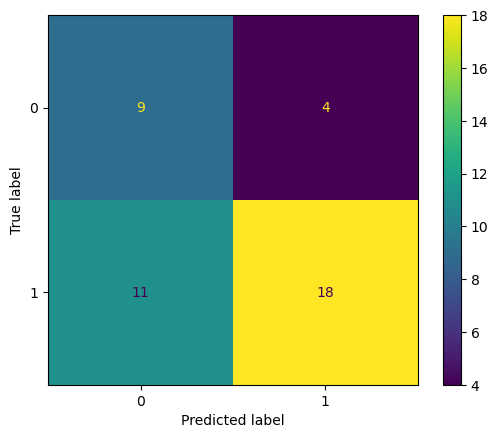

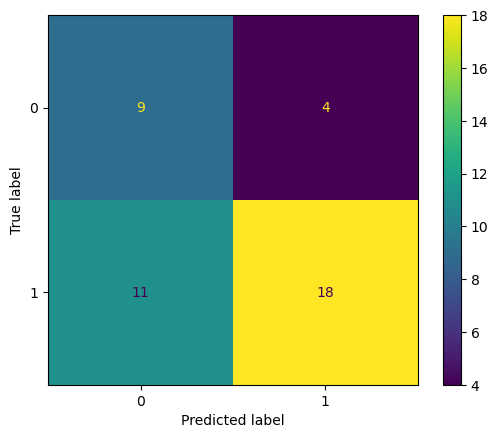

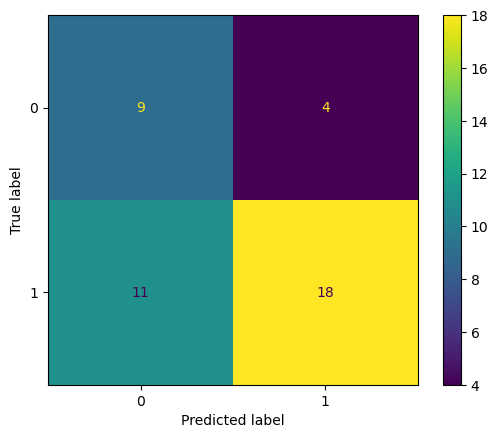

In [55]:
orders = [1,2,3] # hard-coded
log_fitted_model_dict = {}
logreg_pred_dict = {}
# Fit the models and instantiate each model individually
for i, order in enumerate(orders):
    logreg_model = LogisticRegression()
    logreg_model = logreg_model.fit(X_train,y_train)
    log_fitted_model_dict[order] = logreg_model
for order in orders:
    logreg_pred_dict[order] = log_fitted_model_dict[order].predict(X_valid) 
    logreg_pred_dict[order] = pd.Series(logreg_pred_dict[order], index=X_valid.index)
    cm = confusion_matrix(y_valid, logreg_pred_dict[order], labels=logreg_model.classes_)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg_model.classes_)
    print('Lag = %s' %(order))
    cmd.plot()
    print(classification_report(y_valid, logreg_pred_dict[order]))
    print('\n')

## Cross-sectional MLP (Neural Network) Model

Using cross-sectional since the dataframe that will be used already statically assigns the lagged values to its respective column. Shuffling across records does not dynamically change the values of the lagged columns.

### Make copy of historical data (differenced at lag=3)

In [56]:
hist_diff = hist.copy()
lag = 3
hist_diff = hist_diff.diff(periods=lag)

# Inspired by Deniega, J. (2023) ADS 505 Final Project
# Add lagged columns to same index
for i in range(1, lag+1):
    for col in hist_diff.columns:
        lag_col_name = f'{col}_lag{i}'
        hist_diff[lag_col_name] = hist_diff[col].shift(i)

hist_diff = hist_diff.dropna() # Remove missing values due to lags out of range
hist_diff.head()

Open       High        Low      Close  \
Date                                                                    
2022-12-15 00:00:00-05:00   0.187084  -3.642642  -5.434413  -9.175537   
2022-12-16 00:00:00-05:00 -22.910624 -21.791803 -16.027973 -16.677521   
2022-12-19 00:00:00-05:00 -16.125264 -19.608827 -16.040446 -17.361664   
2022-12-20 00:00:00-05:00 -13.121983 -11.090204  -8.176210  -7.228760   
2022-12-21 00:00:00-05:00  -1.908814   0.820898   1.631873   2.927521   

                               Volume  open_close  positive  high_low  \
Date                                                                    
2022-12-15 00:00:00-05:00  42300100.0   -9.362621      -1.0  1.791771   
2022-12-16 00:00:00-05:00  -3924500.0    6.233103       0.0 -5.763831   
2022-12-19 00:00:00-05:00 -28233200.0   -1.236399       0.0 -3.568380   
2022-12-20 00:00:00-05:00 -43278700.0    5.893224       1.0 -2.913995   
2022-12-21 00:00:00-05:00 -41690600.0    4.836335       1.0 -0.810976   

                           Open_lag1  High_lag1   Low_lag1  Close_lag1  \
Date                                                                     
2022-12-15 00:00:00-05:00   6.566610   7.757879   3.111030    6.025146   
2022-12-16 00:00:00-05:00   0.187084  -3.642642  -5.434413   -9.175537   
2022-12-19 00:00:00-05:00 -22.910624 -21.791803 -16.027973  -16.677521   
2022-12-20 00:00:00-05:00 -16.125264 -19.608827 -16.040446  -17.361664   
2022-12-21 00:00:00-05:00 -13.121983 -11.090204  -8.176210   -7.228760   

                           Volume_lag1  open_close_lag1  positive_lag1  \
Date                                                                     
2022-12-15 00:00:00-05:00   26663600.0        -0.541464            0.0   
2022-12-16 00:00:00-05:00   42300100.0        -9.362621           -1.0   
2022-12-19 00:00:00-05:00   -3924500.0         6.233103            0.0   
2022-12-20 00:00:00-05:00  -28233200.0        -1.236399            0.0   
2022-12-21 00:00:00-05:00  -43278700.0         5.893224            1.0   

                           high_low_lag1  Open_lag2  High_lag2   Low_lag2  \
Date                                                                        
2022-12-15 00:00:00-05:00       4.646850  14.846303  12.926543   5.710157   
2022-12-16 00:00:00-05:00       1.791771   6.566610   7.757879   3.111030   
2022-12-19 00:00:00-05:00      -5.763831   0.187084  -3.642642  -5.434413   
2022-12-20 00:00:00-05:00      -3.568380 -22.910624 -21.791803 -16.027973   
2022-12-21 00:00:00-05:00      -2.913995 -16.125264 -19.608827 -16.040446   

                           Close_lag2  Volume_lag2  open_close_lag2  \
Date                                                                  
2022-12-15 00:00:00-05:00    5.641235   63044600.0        -9.205068   
2022-12-16 00:00:00-05:00    6.025146   26663600.0        -0.541464   
2022-12-19 00:00:00-05:00   -9.175537   42300100.0        -9.362621   
2022-12-20 00:00:00-05:00  -16.677521   -3924500.0         6.233103   
2022-12-21 00:00:00-05:00  -17.361664  -28233200.0        -1.236399   

                           positive_lag2  high_low_lag2  Open_lag1_lag2  \
Date                                                                      
2022-12-15 00:00:00-05:00           -1.0       7.216386        1.151864   
2022-12-16 00:00:00-05:00            0.0       4.646850       14.846303   
2022-12-19 00:00:00-05:00           -1.0       1.791771        6.566610   
2022-12-20 00:00:00-05:00            0.0      -5.763831        0.187084   
2022-12-21 00:00:00-05:00            0.0      -3.568380      -22.910624   

                           High_lag1_lag2  Low_lag1_lag2  Close_lag1_lag2  \
Date                                                                        
2022-12-15 00:00:00-05:00        3.258712       1.417698         5.700287   
2022-12-16 00:00:00-05:00       12.926543       5.710157         5.641235   
2022-12-19 00:00:00-05:00        7.757879       3.111030         6.025146   
2022-12-20 00:00:00-0

### Preprocess dataframes for RobustScaler due to expected outlier stock price movements

In [57]:
hist_diff_scale = RobustScaler().fit_transform(hist_diff)
hist_diff_scale = pd.DataFrame(hist_diff_scale, columns=hist_diff.columns, index=hist_diff.index)

# Reset positive column to correct for differencing on all columns
hist_diff_scale['positive'] = hist['positive']
hist_diff_scale.head()

Open      High       Low     Close    Volume  \
Date                                                                          
2022-12-15 00:00:00-05:00 -0.069773 -0.610429 -0.848211 -1.282933  1.312128   
2022-12-16 00:00:00-05:00 -2.927088 -3.048290 -2.232785 -2.220675 -0.034407   
2022-12-19 00:00:00-05:00 -2.087701 -2.755064 -2.234416 -2.306193 -0.742526   
2022-12-20 00:00:00-05:00 -1.716178 -1.610812 -1.206563 -1.039587 -1.180806   
2022-12-21 00:00:00-05:00 -0.329047 -0.010870  0.075349  0.229941 -1.134544   

                           open_close  positive  high_low  Open_lag1  \
Date                                                                   
2022-12-15 00:00:00-05:00   -1.672084         0  0.662236   0.715301   
2022-12-16 00:00:00-05:00    1.110229         0 -2.276874  -0.069374   
2022-12-19 00:00:00-05:00   -0.222347         0 -1.422850  -2.910369   
2022-12-20 00:00:00-05:00    1.049594         1 -1.168295  -2.075777   
2022-12-21 00:00:00-05:00    0.861043         1 -0.350226  -1.706376   

                           High_lag1  Low_lag1  Close_lag1  Volume_lag1  \
Date                                                                      
2022-12-15 00:00:00-05:00   0.915678  0.268674    0.612313     0.856632   
2022-12-16 00:00:00-05:00  -0.606948 -0.848211   -1.272895     1.312128   
2022-12-19 00:00:00-05:00  -3.030904 -2.232785   -2.203300    -0.034407   
2022-12-20 00:00:00-05:00  -2.739351 -2.234416   -2.288148    -0.742526   
2022-12-21 00:00:00-05:00  -1.601625 -1.206563   -1.031453    -1.180806   

                           open_close_lag1  positive_lag1  high_low_lag1  \
Date                                                                       
2022-12-15 00:00:00-05:00        -0.089023            0.0       1.772855   
2022-12-16 00:00:00-05:00        -1.669595           -0.5       0.662236   
2022-12-19 00:00:00-05:00         1.124842            0.0      -2.276874   
2022-12-20 00:00:00-05:00        -0.213541            0.0      -1.422850   
2022-12-21 00:00:00-05:00         1.063942            0.5      -1.168295   

                           Open_lag2  High_lag2  Low_lag2  Close_lag2  \
Date                                                                    
2022-12-15 00:00:00-05:00   1.728812   1.584028  0.593610    0.545591   
2022-12-16 00:00:00-05:00   0.713287   0.903155  0.258795    0.591593   
2022-12-19 00:00:00-05:00  -0.069179  -0.598647 -0.842014   -1.229820   
2022-12-20 00:00:00-05:00  -2.902172  -2.989453 -2.206658   -2.128741   
2022-12-21 00:00:00-05:00  -2.069930  -2.701887 -2.208265   -2.210718   

                           Volume_lag2  open_close_lag2  positive_lag2  \
Date                                                                     
2022-12-15 00:00:00-05:00     1.916421        -1.613836           -0.5   
2022-12-16 00:00:00-05:00     0.856632        -0.078353            0.0   
2022-12-19 00:00:00-05:00     1.312128        -1.641760           -0.5   
2022-12-20 00:00:00-05:00    -0.034407         1.122330            0.0   
2022-12-21 00:00:00-05:00    -0.742526        -0.201519            0.0   

                           high_low_lag2  Open_lag1_lag2  High_lag1_lag2  \
Date                                                                       
2022-12-15 00:00:00-05:00       2.772399        0.049154        0.310475   
2022-12-16 00:00:00-05:00       1.772855        1.728812        1.584028   
2022-12-19 00:00:00-05:00       0.662236        0.713287        0.903155   
2022-12-20 00:00:00-05:00      -2.276874       -0.069179       -0.598647   
2022-12-21 00:00:00-05:00      -1.422850       -2.902172       -2.989453   

                           Low_lag1_lag2  Close_lag1_lag2  Volume_lag1_lag2  \
Date                                                                          
2022-12-15 00:00:00-05:00       0.032068         0.533468          0.361255   
2022-12-16 00:00:00-05:00       0.585015         0.526509          1.944666   
2022-12-19 00:00:00-05:00       0

### Partition

In [58]:
y = hist['positive'] # binary values should not be differenced]['positive'] # binary values should not be differenced
X = hist_diff_scale.drop(['positive'], axis=1)
y = y.reindex(X.index)

# Data partition
end_train_index = 200
X_train = X.iloc[:end_train_index]
X_valid = X.iloc[end_train_index:]

y_train = y.iloc[:end_train_index]
y_valid = y.iloc[end_train_index:]

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape #check lengths of data partitions

((200, 63), (42, 63), (200,), (42,))

### Cross-sectional MLP (Neural Network) Model Fitting and Confusion Matrix

##### Gridsearch for the best set of parameters

In [59]:
# Inspired by Deniega (2023) ADS 505 Final Project
param_grid = {
    'hidden_layer_sizes': [1, 2, 4, 8, 16, 
                           '(2,2)', '(3,3)', '(4,4)', '(5,5)', '(6,6)', '(7,7)', '(8,8)', '(9,9)', '(10,10)', 
                           '(2,2,2)', '(3,3,3)', '(4,4,4)', '(5,5,5)', '(6,6,6)', '(7,7,7)', '(8,8,8)'],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'max_iter': [500, 1000, 2000, 4000]
}

grid_search = GridSearchCV(MLPClassifier(random_state=14), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train,y_train)

best = grid_search.best_estimator_
best

/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/johnv

MLPClassifier(activation='logistic', hidden_layer_sizes=4, max_iter=500,
              random_state=14, solver='lbfgs')

##### Fit parameters to MLP model

In [60]:
# Model and fitting
mlp_model = MLPClassifier(activation='tanh', hidden_layer_sizes=2, max_iter=2000, solver='sgd')
mlp_model.fit(X_train,y_train)

MLPClassifier(activation='tanh', hidden_layer_sizes=2, max_iter=2000,
              solver='sgd')

##### Evaluate model with Confusion Matrix

              precision    recall  f1-score   support

           0       0.91      0.77      0.83        13
           1       0.90      0.97      0.93        29

    accuracy                           0.90        42
   macro avg       0.91      0.87      0.88        42
weighted avg       0.91      0.90      0.90        42



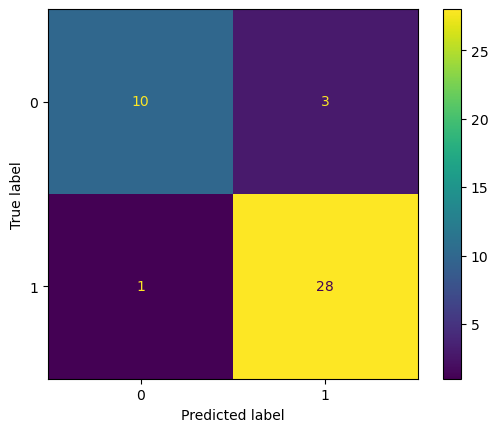

In [61]:
mlp_pred = mlp_model.predict(X_valid)
mlp_pred = pd.Series(mlp_pred, index=X_valid.index)
y_valid = y_valid.reindex(mlp_pred.index)
cm = confusion_matrix(y_valid, mlp_pred, labels=mlp_model.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp_model.classes_)
cmd.plot()
print(classification_report(y_valid, mlp_pred))

## TEST: Try different parameters (hidden layers, solvers, etc.) 

              precision    recall  f1-score   support

           0       0.80      0.92      0.86        13
           1       0.96      0.90      0.93        29

    accuracy                           0.90        42
   macro avg       0.88      0.91      0.89        42
weighted avg       0.91      0.90      0.91        42



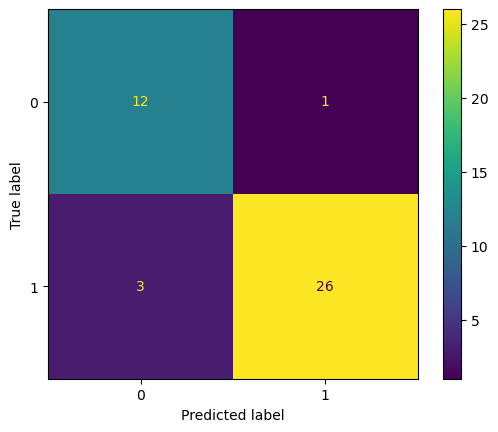

In [62]:
# Model and fitting
mlp_model = MLPClassifier(activation='tanh', hidden_layer_sizes=(3,2), max_iter=4000, solver='sgd',
                         random_state=14)
mlp_model.fit(X_train,y_train)
mlp_pred = mlp_model.predict(X_valid)
mlp_pred = pd.Series(mlp_pred, index=X_valid.index)
y_valid = y_valid.reindex(mlp_pred.index)
cm = confusion_matrix(y_valid, mlp_pred, labels=mlp_model.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp_model.classes_)
cmd.plot()
print(classification_report(y_valid, mlp_pred))

##### Hidden Layers (3,2) shows .95 accuracy!!!

### MLP Regressor

In [63]:
mlpr = hist.copy()

y = hist['Close']
X = mlpr.drop(['Close'], axis=1)
y = y.reindex(X.index)

# Data partition
end_train_index = 200
X_train = X.iloc[:end_train_index]
X_valid = X.iloc[end_train_index:]

y_train = y.iloc[:end_train_index]
y_valid = y.iloc[end_train_index:]

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape #check lengths of data partitions

((200, 7), (51, 7), (200,), (51,))

### MLP Regressor Parameter search

In [64]:
# Inspired by Deniega (2023) ADS 505 Final 
param_grid = {
    'hidden_layer_sizes': [1, 2, 4, 8, 16, 
                           '(2,2)', '(3,2)', '(4,2)', '(5,2)', '(3,3)', '(3,4)', '(3,5)', '(4,3)', '(4,4)', 
                           '(4,5)', '(5,4)', '(5,5)', '(2,2,2)', '(2,2,3)', '(2,3,2)', '(3,2,2)'],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [500, 1000, 2000, 4000]
}

grid_search = GridSearchCV(MLPRegressor(random_state=14), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train,y_train)

best = grid_search.best_estimator_
best

/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: Run

MLPRegressor(alpha=0.01, hidden_layer_sizes=8, max_iter=500, random_state=14,
             solver='lbfgs')

In [65]:
# Model and fitting
mlpr_model = MLPRegressor(alpha=0.01, hidden_layer_sizes=8, max_iter=500, random_state=14,
             solver='lbfgs')
mlpr_model.fit(X_train,y_train)

MLPRegressor(alpha=0.01, hidden_layer_sizes=8, max_iter=500, random_state=14,
             solver='lbfgs')

In [66]:
mlpr_pred = mlpr_model.predict(X_valid)
mlpr_pred = pd.Series(mlpr_pred, index=X_valid.index)
y_valid = y_valid.reindex(mlpr_pred.index)
#close_valid.shape, mlpr_pred.shape
ts_eval_metrics(y_valid, mlpr_pred)

Time Series Evaluation Metrics
MSE = 2.390075356548426
MAE = 1.2111350430319578
RMSE = 1.5459868552314493
MAPE = 0.0028081807852311804
r2 = 0.9853884625041505



## Amazon  - Gabi in progress

In [67]:
# Download market data for Amazon: 

amzn = yf.Ticker("AMZN")
#amzn.history_metadata

In [68]:
# Import Amazon stock dataset: 

amzn = amzn.history(period="5y")
amzn_df = pd.DataFrame(amzn)

display(amzn_df.head(5))
display(amzn_df.tail(5))
display(amzn_df.describe())

Open       High        Low      Close  \
Date                                                                    
2018-12-03 00:00:00-05:00  88.473000  88.917000  86.500000  88.617996   
2018-12-04 00:00:00-05:00  87.800003  88.516998  83.250000  83.419998   
2018-12-06 00:00:00-05:00  80.743500  85.052498  80.492500  84.959503   
2018-12-07 00:00:00-05:00  85.253502  85.946503  81.273003  81.456497   
2018-12-10 00:00:00-05:00  81.192001  82.899498  79.543503  82.051498   

                              Volume  Dividends  Stock Splits  
Date                                                           
2018-12-03 00:00:00-05:00  137246000        0.0           0.0  
2018-12-04 00:00:00-05:00  173890000        0.0           0.0  
2018-12-06 00:00:00-05:00  175788000        0.0           0.0  
2018-12-07 00:00:00-05:00  151522000        0.0           0.0  
2018-12-10 00:00:00-05:00  149896000        0.0           0.0

Open        High         Low       Close  \
Date                                                                        
2023-11-27 00:00:00-05:00  147.529999  149.259995  146.880005  147.729996   
2023-11-28 00:00:00-05:00  146.979996  147.600006  145.529999  147.029999   
2023-11-29 00:00:00-05:00  147.850006  148.539993  145.970001  146.320007   
2023-11-30 00:00:00-05:00  144.759995  146.929993  144.330002  146.089996   
2023-12-01 00:00:00-05:00  146.000000  147.250000  145.550003  147.029999   

                             Volume  Dividends  Stock Splits  
Date                                                          
2023-11-27 00:00:00-05:00  53762400        0.0           0.0  
2023-11-28 00:00:00-05:00  42711700        0.0           0.0  
2023-11-29 00:00:00-05:00  40610900        0.0           0.0  
2023-11-30 00:00:00-05:00  65814000        0.0           0.0  
2023-12-01 00:00:00-05:00  39924600        0.0           0.0

Open         High          Low        Close        Volume  \
count  1258.000000  1258.000000  1258.000000  1258.000000  1.258000e+03   
mean    126.603151   128.164270   124.930277   126.562281  7.752733e+07   
std      31.749957    32.034355    31.382829    31.668992  3.520811e+07   
min      67.300003    69.801498    65.349998    67.197998  1.762600e+07   
25%      94.902876    95.972250    93.748123    94.906998  5.398020e+07   
50%     125.139999   127.099998   123.915001   125.645500  6.694420e+07   
75%     158.346878   159.930752   156.224998   158.093746  9.078215e+07   
max     187.199997   188.654007   184.839493   186.570496  3.113460e+08   

       Dividends  Stock Splits  
count     1258.0   1258.000000  
mean         0.0      0.015898  
std          0.0      0.563884  
min          0.0      0.000000  
25%          0.0      0.000000  
50%          0.0      0.000000  
75%          0.0      0.000000  
max          0.0     20.000000

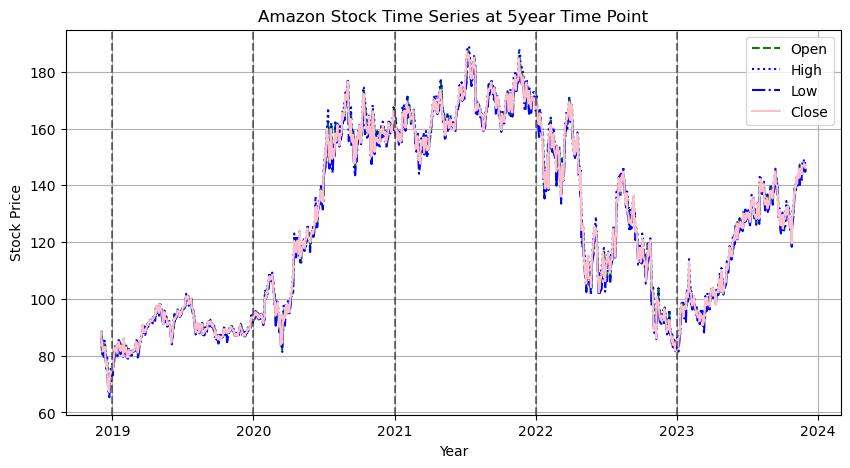

In [69]:
# Plot initial Amazon stock time series at 5y time point: 

plt.figure(figsize=(10, 5))
plt.plot(amzn_df['Open'], label='Open', color='green', linestyle='--')
plt.plot(amzn_df['High'], label='High', color='blue', linestyle='dotted')
plt.plot(amzn_df['Low'], label='Low', color='blue', linestyle='dashdot')
plt.plot(amzn_df['Close'], label='Close', color='pink')

for year in range(2019,2024):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)

    
plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.title('Amazon Stock Time Series at 5year Time Point')
plt.legend()
plt.grid(True)
plt.show()

### Partition train and validation datasets 

In [70]:
# Partition train and validation datasets: 

past_year0 = amzn_df.iloc[-252:] # 252 trading days per year
b_past_year = amzn_df.iloc[:-len(past_year0)] 
                           
train = b_past_year['Close'].asfreq('D')
amzn_train = train.ffill()

valid = amzn_df.iloc[-len(past_year0):]
val_close = valid['Close'].asfreq('D')
val_close = val_close.ffill()

### Test of Stationarity

In [71]:
# Determine dataset stationarity: 
# H0 = time series not stationary; H1 = time series is stationary

result = adfuller(amzn_train )
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])
print('Time series is not stationary')

ADF Statistic: -1.483494
p-value: 0.541660
Critical Values:
{'1%': -3.434846127900848, '5%': -2.8635257411342616, '10%': -2.5678271914441395}
Time series is not stationary


### STL Decoposition Using Locally Estimated Scatterplot Smoothing (LOESS)

In [72]:
# Fit close stock price dataset to STL: 

stl = STL(amzn_df['Close'], period=12)
result = stl.fit()


# Identify seasonal, trend, resid:

seasonal, trend, resid = result.seasonal, result.trend, result.resid

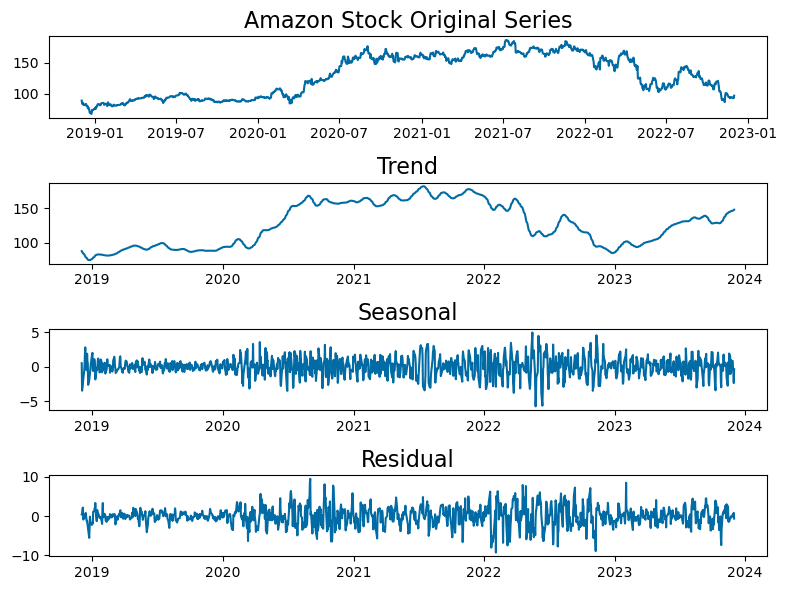

In [73]:
# Plot decomposition:

plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(amzn_train)
plt.title('Amazon Stock Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

### Holt-Winters Smoothing

In [74]:
# Looking at overall trend with Holt's Winter Smoothing

hw_model = ExponentialSmoothing(amzn_train,
                    trend='add', seasonal='add', seasonal_periods=4)
result_hw = hw_model.fit()

amzn_smo_fore = amzn_train.copy()
amzn_smo_fore['Forecast'] = result_hw.fittedvalues
amzn_smo_fore = pd.to_numeric(amzn_smo_fore, errors='coerce')
amzn_smo_fore.dropna(inplace=True)

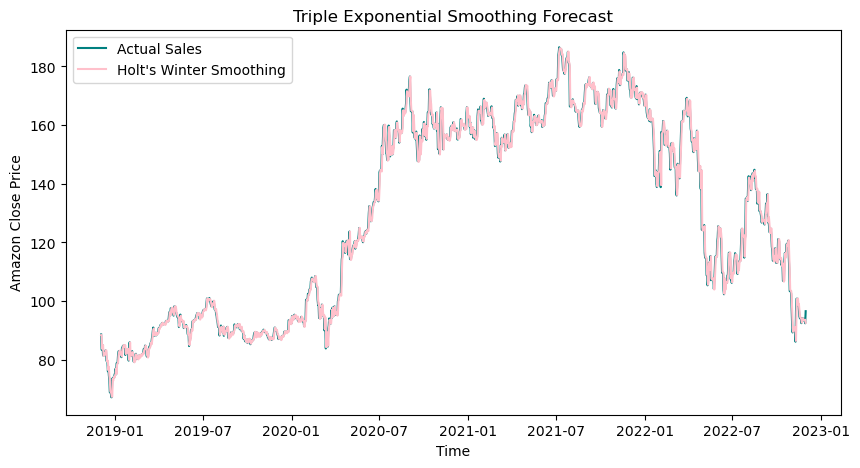

In [75]:
# Plot Holt's Winter Smoothing:

plt.figure(figsize=(10, 5))
plt.plot(amzn_smo_fore, label='Actual Sales', color = 'Teal', marker='')
plt.plot(result_hw.fittedvalues, label="Holt's Winter Smoothing", color = 'pink')
plt.xlabel('Time')
plt.ylabel('Amazon Close Price')
plt.title('Triple Exponential Smoothing Forecast')
plt.legend()
plt.show()

### Anomaly Detection

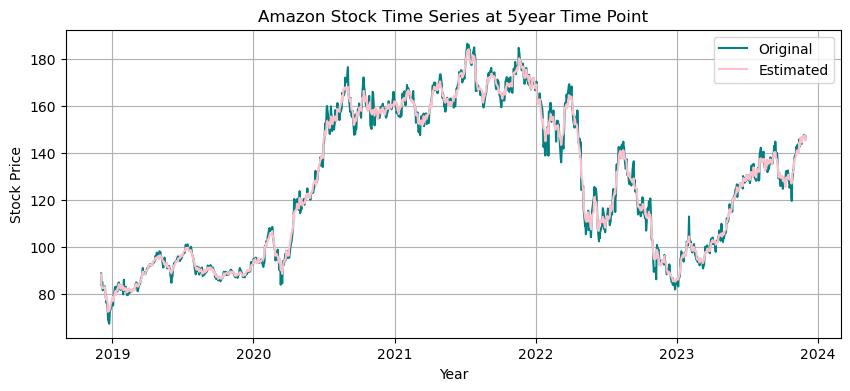

In [76]:
# Plot original Amazon Close time series vs Forecasted time series: 

estimated = trend + seasonal # from STL
plt.figure(figsize=(10,4))
plt.plot(amzn_df['Close'], label='Original', color = 'teal')
plt.plot(estimated, label ='Estimated', color = 'pink')

plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.title('Amazon Stock Time Series at 5year Time Point')
plt.legend()
plt.grid(True)
plt.show()

In [77]:
# Taking residuals and detecting anomaly at 3std. dev: 

resid_mu = resid.mean()
resid_dev = resid.std()

lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev

Text(0.5, 1.0, 'Amazon at 5year Time Point')

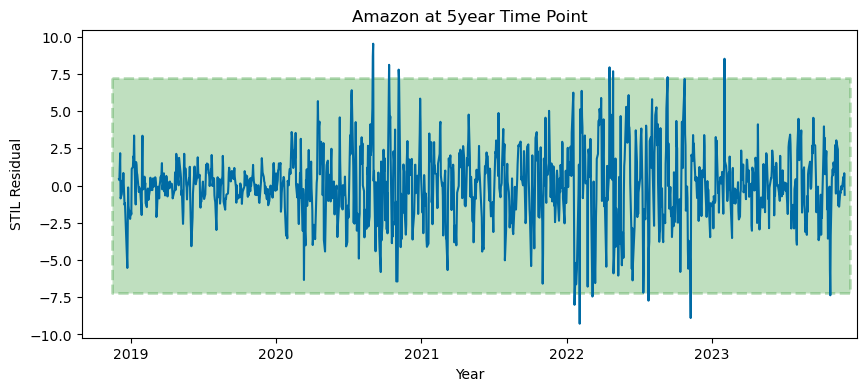

In [78]:
# Plot residual threshold: 

plt.figure(figsize=(10,4))
plt.plot(resid)

plt.fill_between([datetime(2018,11,15), datetime(2023,12,15)], lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2)
plt.xlim(datetime(2018,9,1), datetime(2024,1,1))

plt.xlabel('Year')
plt.ylabel('STIL Residual')
plt.title('Amazon at 5year Time Point')

In [79]:
# Identify anomalies by setting the residuals upper and lower limits:

anomalies = amzn_df['Close'][(resid < lower) | (resid > upper)]
anomalies = pd.DataFrame(anomalies)

Text(0.5, 1.0, 'Amazon: Anomalies Marked at 3 Std Dev or 99.7% within Normal Distribution')

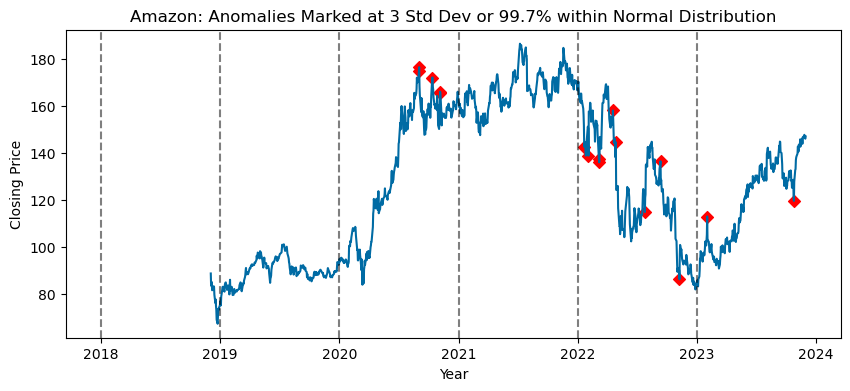

In [80]:
# Plot identified residual anomalies:    ********In Progress*******

plt.figure(figsize=(10,4))
plt.plot(amzn_df['Close'])

for year in range(2018,2024):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)
    
plt.scatter(anomalies.index, anomalies.Close, color='r', marker='D')
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.title('Amazon: Anomalies Marked at 3 Std Dev or 99.7% within Normal Distribution')

In [81]:
# Anomalies identified outside 3std dev of residuals: 

anomalies.head()

Close
Date                                 
2020-09-01 00:00:00-04:00  174.955994
2020-09-02 00:00:00-04:00  176.572495
2020-10-12 00:00:00-04:00  172.146500
2020-11-05 00:00:00-05:00  166.100006
2020-11-06 00:00:00-05:00  165.568497

### Transforming Time Series to Stationary

Text(0, 0.5, 'Amazon Stock Closing Price \n(First Diff.)')

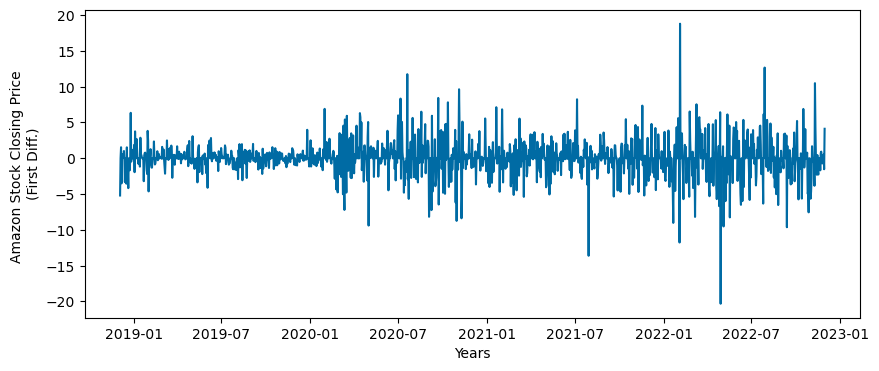

In [82]:
# Removing trend by applying the first Difference: 

diff_ts = amzn_train.diff().dropna()

# Plot first difference: 

plt.figure(figsize=(10,4))
plt.plot(diff_ts)

plt.xlabel('Years', fontsize=10)
plt.ylabel('Amazon Stock Closing Price \n(First Diff.)', fontsize=10)

In [83]:
# Determine dataset stationarity: 
# H0 = time series not stationary; H1 = time series is stationary

result = adfuller(diff_ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])
print('Time series is stationary')

ADF Statistic: -39.915813
p-value: 0.000000
Critical Values:
{'1%': -3.434846127900848, '5%': -2.8635257411342616, '10%': -2.5678271914441395}
Time series is stationary


### Selecting a Model

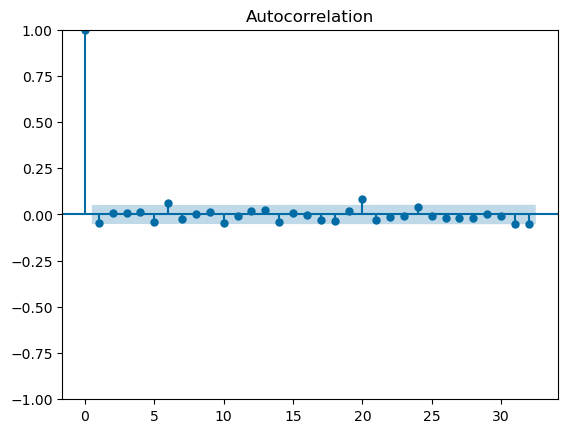

None

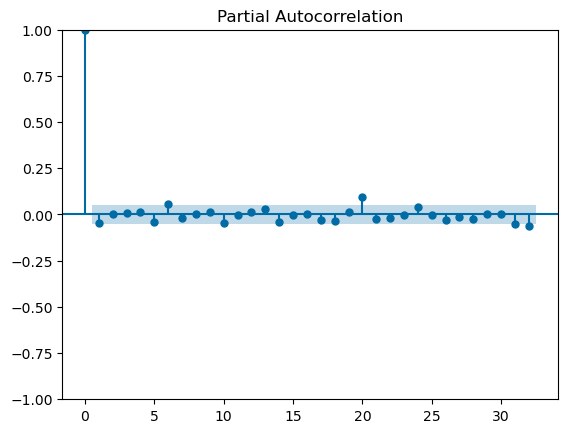

None

In [84]:
# ACF suggest MA Lag 1, 6, 10, 20, 31, 32 

plot_acf(diff_ts)
display(plt.show())

# PACF suggest AR Lag 1, 6, 10, 20, 31, 32

plot_pacf(diff_ts, method='ywm')
display(plt.show())

#### Model Selection Criteria: 

>BIC = $\ln(n)k$ - 2$l$
>
>AIC = 2$k$ - 2$l$


>($l$) = a log likelihood 
>
>($k$) = a number of parameters 
>
>($n$) = a number of samples used for fitting


#### Auto-ARIMA Model 

In [85]:
# Auto ARIMA Model: 

auto_arima_model = auto_arima(amzn_train, d=1, seasonal=True, stepwise=True, trace=True)
auto_arima_model.summary()

arima_pred0 = auto_arima_model.predict(n_periods=len(val_close))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6726.667, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6732.539, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6731.612, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6731.649, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6730.546, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6735.459, Time=0.41 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6735.478, Time=0.25 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6734.079, Time=0.73 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6731.617, Time=0.52 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6733.584, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6736.231, Time=0.25 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6737.434, Time=0.21 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=6733.522, Time=0.89 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=6724.420, Time=0.38 sec
 ARIMA(1,1,2)(0,0,0)[0]          

In [86]:
# ARIMA Model and Forecast at ARIMA(2,1,2): 

# p = number of lag observations, lag order
# d = number of raw observations differenced, degree of differencing
# q = size of moving average window, order of moving average

arima_m = sm.tsa.ARIMA(amzn_train, order=(2,1,2)).fit() 
print(arima_m.summary())

arima_pred1 = arima_m.forecast(steps=len(val_close))

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1459
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3357.210
Date:                Sat, 02 Dec 2023   AIC                           6724.420
Time:                        16:08:48   BIC                           6750.844
Sample:                    12-03-2018   HQIC                          6734.278
                         - 11-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5445      0.020    -27.637      0.000      -0.583      -0.506
ar.L2         -0.9619      0.017    -55.070      0.000      -0.996      -0.928
ma.L1          0.5218      0.018     29.309      0.0

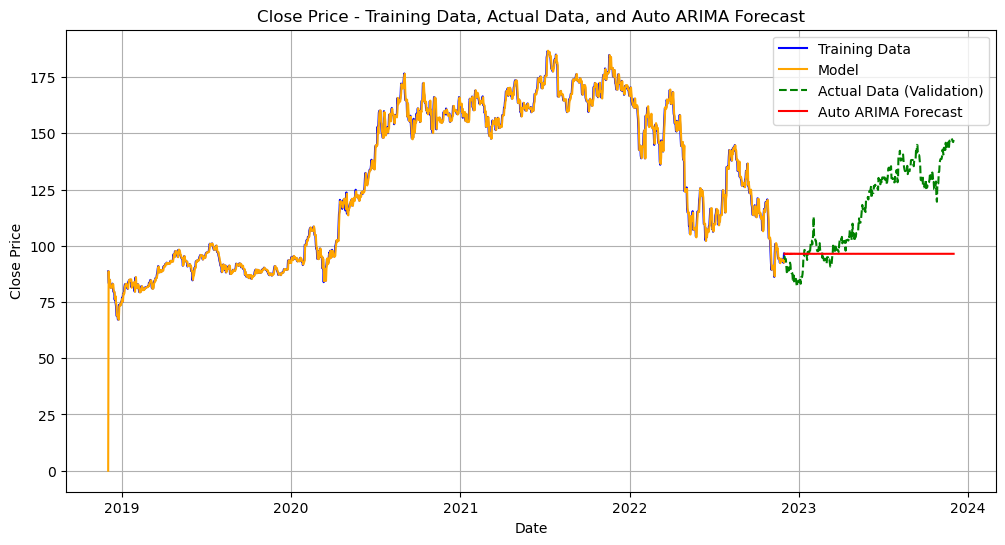

In [87]:
# Plot Auto ARIMA Result:

plt.figure(figsize=(12, 6))
plt.plot(amzn_train, label='Training Data', color='blue')
plt.plot(arima_m.fittedvalues, label="Model", color = 'orange') 
plt.plot(val_close, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(val_close.index, arima_pred1, label='Auto ARIMA Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and Auto ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()

#### ARIMA Model

In [88]:
# AR lag optimization:

ar_orders0 = [1, 6, 10, 20, 31, 32]
fitted_model_dict = {}

for i, ar_order0 in enumerate(ar_orders0):
    ar_model0 = sm.tsa.arima.ARIMA(amzn_train, order=(ar_order0,1,1),trend='n') 
    ar_model_fit0 = ar_model0.fit()
    fitted_model_dict[ar_order0] = ar_model_fit0

for ar_order0 in ar_orders0:
    print('AIC for AR(%s): %s' %(ar_order0, fitted_model_dict[ar_order0].aic))
    print('BIC for AR(%s): %s' %(ar_order0, fitted_model_dict[ar_order0].bic))
    print('\n')

AIC for AR(1): 6731.592065905804
BIC for AR(1): 6747.44652864351


AIC for AR(6): 6733.544745494484
BIC for AR(6): 6775.823312795033


AIC for AR(10): 6737.693989201631
BIC for AR(10): 6801.111840152454


AIC for AR(20): 6737.335179933416
BIC for AR(20): 6853.601240009925


AIC for AR(31): 6746.017337740084
BIC for AR(31): 6920.416427854848


AIC for AR(32): 6743.363582853918
BIC for AR(32): 6923.04749388125




##### Result: 

AR order 1 has the lowest AIC and BIC scores. 

In [89]:
# MA lag optimization:

ma_orders0 = [1, 6, 10, 20, 31, 32]
fitted_model_dict = {}

for i, ma_order0 in enumerate(ma_orders0):
    ma_model0 = sm.tsa.arima.ARIMA(amzn_train, order=(1,1,ma_order0),trend='n') 
    ma_model_fit0 = ma_model0.fit()
    fitted_model_dict[ma_order0] = ma_model_fit0

for ma_order0 in ma_orders0:
    print('AIC for AR(%s): %s' %(ma_order0, fitted_model_dict[ma_order0].aic))
    print('BIC for AR(%s): %s' %(ma_order0, fitted_model_dict[ma_order0].bic))
    print('\n')

AIC for AR(1): 6731.592065905804
BIC for AR(1): 6747.44652864351


AIC for AR(6): 6733.166730699869
BIC for AR(6): 6775.445298000418


AIC for AR(10): 6738.248742967944
BIC for AR(10): 6801.666593918767


AIC for AR(20): 6735.346368040603
BIC for AR(20): 6851.612428117112


AIC for AR(31): 6745.511888587229
BIC for AR(31): 6919.9109787019925


AIC for AR(32): 6744.8983547098915
BIC for AR(32): 6924.582265737224




##### Result: 

MA order 1 has the lowest AIC and BIC scores. 

In [90]:
# ARIMA Model and Forecast at ARIMA(1,1,1): 

# p = number of lag observations, lag order
# d = number of raw observations differenced, degree of differencing
# q = size of moving average window, order of moving average

arima_m0 = sm.tsa.ARIMA(amzn_train, order=(1,1,1)).fit() 
print(arima_m0.summary())

arima_pred2 = arima_m0.forecast(steps=len(val_close))

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1459
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3362.796
Date:                Sat, 02 Dec 2023   AIC                           6731.592
Time:                        16:09:47   BIC                           6747.447
Sample:                    12-03-2018   HQIC                          6737.507
                         - 11-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1283      0.578     -0.222      0.824      -1.260       1.004
ma.L1          0.0835      0.577      0.145      0.885      -1.047       1.214
sigma2         5.9003      0.106     55.775      0.0

In [91]:
# Statistical Metrics:

print('AIC = %s' %(arima_m0.aic))
print('BIC = %s' %(arima_m0.bic))
arima0_metrics = ts_eval_metrics(val_close, arima_pred2)

AIC = 6731.592065905804
BIC = 6747.44652864351
Time Series Evaluation Metrics
MSE = 754.8545678338945
MAE = 22.217022472025857
RMSE = 27.474616791393007
MAPE = 0.17439483531379377
r2 = -1.0895229986377566



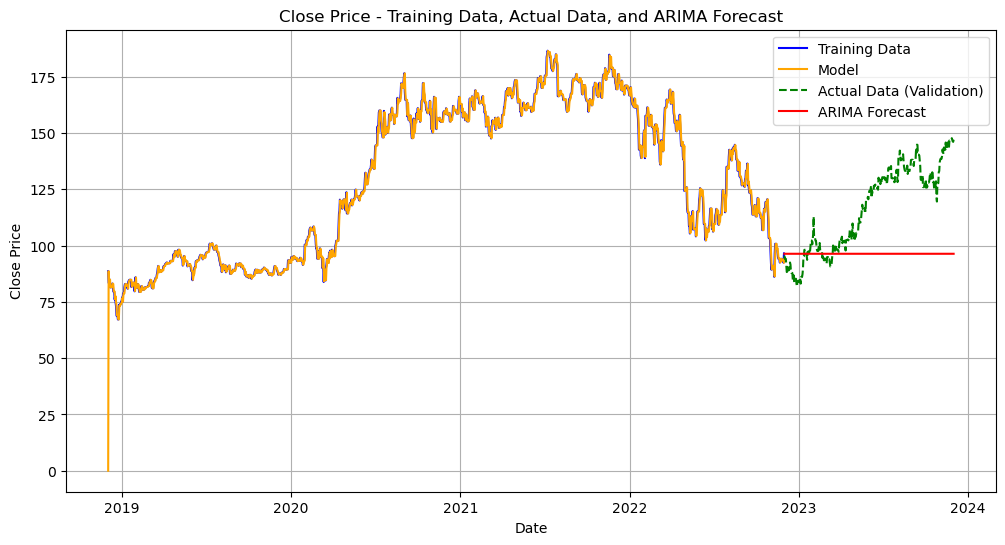

In [92]:
# Plot ARIMA Result:

plt.figure(figsize=(12, 6))
plt.plot(amzn_train, label='Training Data', color='blue')
plt.plot(arima_m0.fittedvalues, label="Model", color = 'orange') 
plt.plot(val_close, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(val_close.index, arima_pred2, label='ARIMA Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()

#### AES Model

In [93]:
# Define AES parameters for optimization:

aes_param_trend0 = ['add', 'mul', None]
aes_param_seasonal0 = ['add', 'mul', None] # set to mul by default
aes_param_initial_method0 = [None, 'estimated', 'heuristic', 'legacy-heuristic']


fitted_model_dict0 = {}

In [94]:
# Trend parameter optimization:

for i in aes_param_trend0:
    aes_model2 = ExponentialSmoothing(amzn_train, 
                                     trend=i, 
                                     damped_trend=False, # Error message: Can only dampen the trend component
                                     seasonal= 'mul',
                                     seasonal_periods= 252, 
                                     initialization_method='heuristic'
                                    ) 
    aes_model2 = aes_model2.fit(
                             )
    
    print('Results for Trend %s' % (i))
    print('AIC = %s' %(aes_model2.aic))
    print('BIC = %s' %(aes_model2.bic))
    aes_pred2 = aes_model2.forecast(steps=len(val_close))
    aes_eval_metrics2 = ts_eval_metrics(val_close, aes_pred2)

Results for Trend add
AIC = 2936.0027343187917
BIC = 4289.0924107406245
Time Series Evaluation Metrics
MSE = 580.5718873229332
MAE = 19.15990459984595
RMSE = 24.09505939654296
MAPE = 0.14925176302329593
r2 = -0.6070887858636413

Results for Trend mul
AIC = 2936.761684759928
BIC = 4289.851361181761
Time Series Evaluation Metrics
MSE = 551.1487855689255
MAE = 18.66124603856165
RMSE = 23.47655821386358
MAPE = 0.14541344792603147
r2 = -0.5256423054075721

Results for Trend None
AIC = 2931.841296969726
BIC = 4274.359960294513
Time Series Evaluation Metrics
MSE = 881.3901501829079
MAE = 23.914700308608563
RMSE = 29.688215678664623
MAPE = 0.1865343906778877
r2 = -1.4397878320652016



##### Result

No trend parameter has the lowest AIC and BIC scores. 

In [95]:
# Initialization method optimization:

for i in aes_param_initial_method0:
    aes_model3 = ExponentialSmoothing(amzn_train, 
                                     trend= None, 
                                     seasonal= 'mul', 
                                     seasonal_periods= 252, 
                                     initialization_method=i
                                    ) 
    aes_model3 = aes_model3.fit(
                             )
    
    print('Results for Initialization Method %s' % (i))
    print('AIC = %s' %(aes_model3.aic))
    print('BIC = %s' %(aes_model3.bic))
    aes_pred3 = aes_model3.forecast(steps=len(val_close))
    aes_eval_metrics3 = ts_eval_metrics(val_close, aes_pred3)

Results for Initialization Method None
AIC = 3621.600050594651
BIC = 4964.118713919438
Time Series Evaluation Metrics
MSE = 1161.4376879722893
MAE = 30.04334440640511
RMSE = 34.07987218245235
MAPE = 0.2446563421963272
r2 = -2.2149911571268235

Results for Initialization Method estimated
AIC = 2772.6864212103314
BIC = 4115.205084535119
Time Series Evaluation Metrics
MSE = 1029.0101489488964
MAE = 26.576815504097297
RMSE = 32.0781880558877
MAPE = 0.20949352926689419
r2 = -1.848416719833005

Results for Initialization Method heuristic
AIC = 2931.841296969726
BIC = 4274.359960294513
Time Series Evaluation Metrics
MSE = 881.3901501829079
MAE = 23.914700308608563
RMSE = 29.688215678664623
MAPE = 0.1865343906778877
r2 = -1.4397878320652016

Results for Initialization Method legacy-heuristic
AIC = 3621.600050594651
BIC = 4964.118713919438
Time Series Evaluation Metrics
MSE = 1161.4376879722893
MAE = 30.04334440640511
RMSE = 34.07987218245235
MAPE = 0.2446563421963272
r2 = -2.2149911571268235



##### Result

For initialization method, heuristic and estimated methods performed the best. 

In [96]:
# Final AES Model on train dataset: 

aes_modelf = ExponentialSmoothing(amzn_train, 
                                 trend= None,
                                 seasonal= 'mul', # set by default, add is poor performer visually
                                 seasonal_periods= 252, #252 trading days per year forecast
                                 initialization_method='heuristic') 

aes_modelf = aes_modelf.fit(smoothing_level=.5, 
                              smoothing_trend=.5)
                           

aes_predf = aes_modelf.forecast(steps=len(val_close))
aes_eval_metricsf = ts_eval_metrics(val_close, aes_predf)

print('AIC = %s' %(aes_modelf.aic))
print('BIC = %s' %(aes_modelf.bic))

Time Series Evaluation Metrics
MSE = 928.7933532307424
MAE = 24.69909028510476
RMSE = 30.47611118943397
MAPE = 0.19287876221935255
r2 = -1.5710052707590902

AIC = 3280.407600449128
BIC = 4622.926263773916


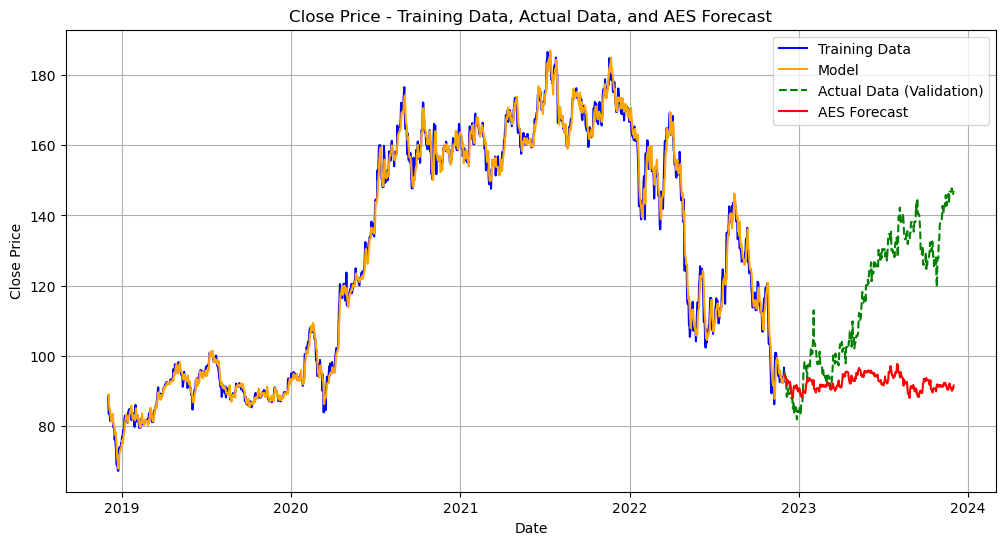

In [97]:
# Plot ARIMA Result:

plt.figure(figsize=(12, 6))
plt.plot(amzn_train, label='Training Data', color='blue')
plt.plot(aes_modelf.fittedvalues, label="Model", color = 'orange') 
plt.plot(val_close, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(val_close.index, aes_predf, label='AES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and AES Forecast')
plt.legend()
plt.grid(True)
plt.show()

#### Logistic Regression

In [98]:
# Pull 1 year Amazon history log: 

amzn_1 = yf.Ticker("AMZN")
hist0 = amzn_1.history(period = '1y')


# Create new predictors and outcome variables: 

hist0['open_close'] = hist0['Close'] - hist0['Open']
hist0['positive'] = np.where(hist0['open_close'] > 0, 1, 0)

hist0['high_low'] = hist0['High'] - hist0['Low']
hist0 = hist0.drop(['Dividends', 'Stock Splits'], axis=1) 

hist0.head()

Open       High        Low      Close  \
Date                                                                    
2022-12-02 00:00:00-05:00  94.480003  95.360001  93.779999  94.129997   
2022-12-05 00:00:00-05:00  93.050003  94.059998  90.820000  91.010002   
2022-12-06 00:00:00-05:00  90.500000  91.040001  87.900002  88.250000   
2022-12-07 00:00:00-05:00  88.339996  89.889999  87.480003  88.459999   
2022-12-08 00:00:00-05:00  89.239998  90.860001  87.879997  90.349998   

                             Volume  open_close  positive  high_low  
Date                                                                 
2022-12-02 00:00:00-05:00  72496400   -0.350006         0  1.580002  
2022-12-05 00:00:00-05:00  71535500   -2.040001         0  3.239998  
2022-12-06 00:00:00-05:00  75503600   -2.250000         0  3.139999  
2022-12-07 00:00:00-05:00  68086900    0.120003         1  2.409996  
2022-12-08 00:00:00-05:00  73305900    1.110001         1  2.980003

In [116]:
hist0['Date'] = pd.to_datetime(hist0.index)
hist0.insert(0, 'day_of_week', hist0['Date'].dt.day_name())
hist0.head()

day_of_week       Open       High        Low  \
Date                                                                     
2022-12-02 00:00:00-05:00      Friday  94.480003  95.360001  93.779999   
2022-12-05 00:00:00-05:00      Monday  93.050003  94.059998  90.820000   
2022-12-06 00:00:00-05:00     Tuesday  90.500000  91.040001  87.900002   
2022-12-07 00:00:00-05:00   Wednesday  88.339996  89.889999  87.480003   
2022-12-08 00:00:00-05:00    Thursday  89.239998  90.860001  87.879997   

                               Close    Volume  open_close  positive  \
Date                                                                   
2022-12-02 00:00:00-05:00  94.129997  72496400   -0.350006         0   
2022-12-05 00:00:00-05:00  91.010002  71535500   -2.040001         0   
2022-12-06 00:00:00-05:00  88.250000  75503600   -2.250000         0   
2022-12-07 00:00:00-05:00  88.459999  68086900    0.120003         1   
2022-12-08 00:00:00-05:00  90.349998  73305900    1.110001         1   

                           high_low                      Date  
Date                                                           
2022-12-02 00:00:00-05:00  1.580002 2022-12-02 00:00:00-05:00  
2022-12-05 00:00:00-05:00  3.239998 2022-12-05 00:00:00-05:00  
2022-12-06 00:00:00-05:00  3.139999 2022-12-06 00:00:00-05:00  
2022-12-07 00:00:00-05:00  2.409996 2022-12-07 00:00:00-05:00  
2022-12-08 00:00:00-05:00  2.980003 2022-12-08 00:00:00-05:00

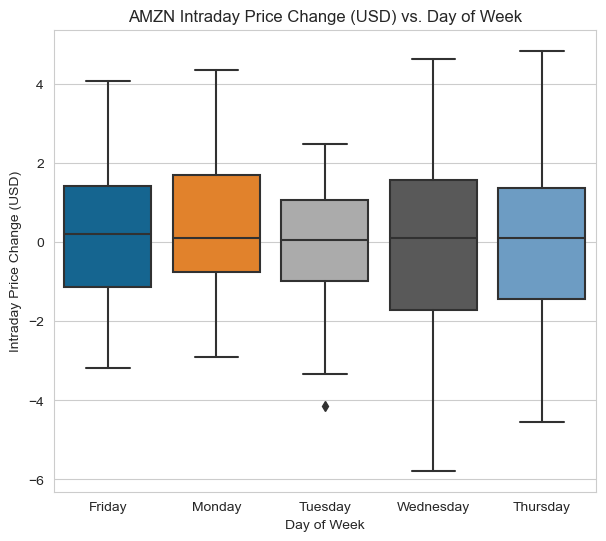

In [117]:
target_y = 'open_close'
column_x = 'day_of_week'

plt.figure(figsize=(7, 6))
sns.boxplot(x=column_x, y=target_y, data=hist0)
sns.set_style("whitegrid")
plt.title("AMZN Intraday Price Change (USD) vs. Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Intraday Price Change (USD)")
plt.show()

In [119]:
day_week_stats = hist0.groupby('day_of_week').describe().transpose()
display(day_week_stats.loc['open_close'])

day_of_week     Friday     Monday   Thursday    Tuesday  Wednesday
count        52.000000  45.000000  51.000000  51.000000  52.000000
mean          0.324807   0.278667   0.083725  -0.097843  -0.048653
std           1.873431   1.642528   2.072043   1.584903   2.221442
min          -3.190002  -2.899994  -4.559998  -4.139992  -5.779999
25%          -1.144995  -0.750000  -1.435001  -0.974998  -1.712503
50%           0.204998   0.110001   0.110001   0.050003   0.109997
75%           1.427505   1.690002   1.380001   1.064999   1.579996
max           4.070000   4.350006   4.839996   2.470001   4.620003

In [99]:
hist0_lag = hist0.copy()

lag = 3

hist0_lag = hist0_lag.diff(periods=lag)

for i in range(1, lag+1):
    for col in hist0_lag.columns:
        lag_col_name = f'{col}_lag{i}'
        hist0_lag[lag_col_name] = hist0_lag[col].shift(i)

hist0_lag = hist0_lag.dropna()

In [100]:
pd.set_option('display.max_columns', 70)
display(hist0_lag.head())

Open      High       Low     Close      Volume  \
Date                                                                            
2022-12-15 00:00:00-05:00  0.680000 -0.610001 -0.400002 -2.100006  22803100.0   
2022-12-16 00:00:00-05:00 -6.960007 -6.900002 -3.789993 -4.629997  45932100.0   
2022-12-19 00:00:00-05:00 -4.989998 -5.830002 -5.360001 -6.660004  13233500.0   
2022-12-20 00:00:00-05:00 -4.559998 -3.360001 -3.139999 -3.259995 -10454600.0   
2022-12-21 00:00:00-05:00 -2.089996 -2.119995 -1.520004 -1.090004 -86876900.0   

                           open_close  positive  high_low  Open_lag1  \
Date                                                                   
2022-12-15 00:00:00-05:00   -2.780006      -1.0 -0.209999   3.599998   
2022-12-16 00:00:00-05:00    2.330009       0.0 -3.110008   0.680000   
2022-12-19 00:00:00-05:00   -1.670006       0.0 -0.470001  -6.960007   
2022-12-20 00:00:00-05:00    1.300003       0.0 -0.220001  -4.989998   
2022-12-21 00:00:00-05:00    0.999992       1.0 -0.599991  -4.559998   

                           High_lag1  Low_lag1  Close_lag1  Volume_lag1  \
Date                                                                      
2022-12-15 00:00:00-05:00   3.159996  1.240005    2.490005    2899500.0   
2022-12-16 00:00:00-05:00  -0.610001 -0.400002   -2.100006   22803100.0   
2022-12-19 00:00:00-05:00  -6.900002 -3.789993   -4.629997   45932100.0   
2022-12-20 00:00:00-05:00  -5.830002 -5.360001   -6.660004   13233500.0   
2022-12-21 00:00:00-05:00  -3.360001 -3.139999   -3.259995  -10454600.0   

                           open_close_lag1  positive_lag1  high_low_lag1  \
Date                                                                       
2022-12-15 00:00:00-05:00        -1.109993           -1.0       1.919991   
2022-12-16 00:00:00-05:00        -2.780006           -1.0      -0.209999   
2022-12-19 00:00:00-05:00         2.330009            0.0      -3.110008   
2022-12-20 00:00:00-05:00        -1.670006            0.0      -0.470001   
2022-12-21 00:00:00-05:00         1.300003            0.0      -0.220001   

                           Open_lag2  High_lag2  Low_lag2  Close_lag2  \
Date                                                                    
2022-12-15 00:00:00-05:00   5.990005   5.389999  2.639999    2.139999   
2022-12-16 00:00:00-05:00   3.599998   3.159996  1.240005    2.490005   
2022-12-19 00:00:00-05:00   0.680000  -0.610001 -0.400002   -2.100006   
2022-12-20 00:00:00-05:00  -6.960007  -6.900002 -3.789993   -4.629997   
2022-12-21 00:00:00-05:00  -4.989998  -5.830002 -5.360001   -6.660004   

                           Volume_lag2  open_close_lag2  positive_lag2  \
Date                                                                     
2022-12-15 00:00:00-05:00   26906100.0        -3.850006           -1.0   
2022-12-16 00:00:00-05:00    2899500.0        -1.109993           -1.0   
2022-12-19 00:00:00-05:00   22803100.0        -2.780006           -1.0   
2022-12-20 00:00:00-05:00   45932100.0         2.330009            0.0   
2022-12-21 00:00:00-05:00   13233500.0        -1.670006            0.0   

                           high_low_lag2  Open_lag1_lag2  High_lag1_lag2  \
Date                                                                       
2022-12-15 00:00:00-05:00       2.750000        0.870003        0.690002   
2022-12-16 00:00:00-05:00       1.919991        5.990005        5.389999   
2022-12-19 00:00:00-05:00      -0.209999        3.599998        3.159996   
2022-12-20 00:00:00-05:00      -3.110008        0.680000       -0.610001   
2022-12-21 00:00:00-05:00      -0.470001       -6.960007       -6.900002   

                           Low_lag1_lag2  Close_lag1_lag2  Volume_lag1_lag2  \
Date                                                                          
2022-12-15 00:00:00-05:00       0.389999         2.090004        -6087100.0   
2022-12-16 00:00:00-05:00       2.639999         2.139999        26906100.0   
2022-12-19 00:00:00

              precision    recall  f1-score   support

           0       0.25      0.29      0.27        14
           1       0.62      0.57      0.59        28

    accuracy                           0.48        42
   macro avg       0.43      0.43      0.43        42
weighted avg       0.49      0.48      0.48        42



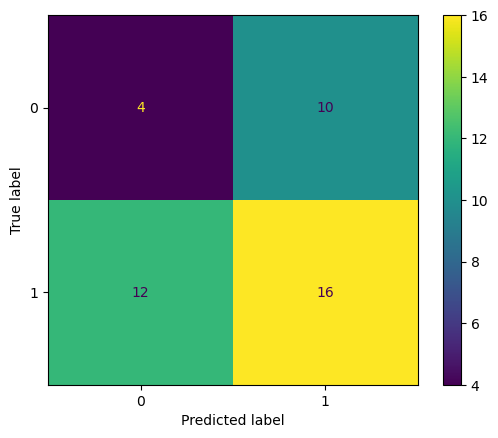

In [101]:
# Data partition for logistic regression:

y1 = hist0['positive'] 
X1 = hist0_lag.drop(['positive'], axis=1)
y1 = y1.reindex(X1.index)

end_train_index1 = 200
X1_train = X1.iloc[:end_train_index1]
X1_valid = X1.iloc[end_train_index1:]

y1_train = y1.iloc[:end_train_index1]
y1_valid = y1.iloc[end_train_index1:]


# Logistic regression model and fitting: 

logreg_model1 = LogisticRegression()
logreg_model1.fit(X1_train,y1_train)


# Model Performance

logreg_pred1 = logreg_model1.predict(X1_valid) 
logreg_pred1 = pd.Series(logreg_pred1, index=X1_valid.index)
y1_valid = y1_valid.reindex(logreg_pred1.index)

cm1 = confusion_matrix(y1_valid, logreg_pred1, labels=logreg_model1.classes_)
cmd1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=logreg_model1.classes_)
cmd1.plot()

print(classification_report(y1_valid, logreg_pred1))

#### Cross-sectional MLP (Neural Network)   ****IP

###### Code References: 
    
 https://github.com/ritvikmath/Time-Series-Analysis/blob/master/STL%20Decomposition.ipynb   
    